# Выпускной проект: промышленность

**Цель исследования:** 
Разработка предсказательной модели температуры сплава.

**Описание проекта:**
Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. 

Заказчик хочет использовать разработанную модель для имитации технологического процесса. 

*Описание этапа обработки:*

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

**Описание данных:**

Данные состоят из нескольких файлов, полученных из разных источников:

<u>Файл data_arc_new.csv</u> — данные об электродах

<u>Файл data_bulk_new.csv</u> — данные о подаче сыпучих материалов (объём)

<u>Файл data_bulk_time_new.csv</u> — данные о подаче сыпучих материалов (время)

<u>Файл data_gas_new.csv</u> — данные о продувке сплава газом

<u>Файл data_temp_new.csv</u> — результаты измерения температуры

<u>Файл data_wire_new.csv</u> — данные о проволочных материалах (объём)

<u>Файл data_wire_time_new.csv</u> — данные о проволочных материалах (время)

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

**План работы:**

* Шаг 1. Загрузка данных

Загрузим данные и выполним их первичный осмотр.

* Шаг 2. Исследовательский анализ и предобработка данных

Выполним исследовательский анализ каждого датафрейма и предобработку. Сделаем выводы об имеющихся признаках: понадобятся ли они для обучения моделей.

* Шаг 3. Объединение данные

Объединим выбранные вами признаки в один датафрейм по ключу.

* Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма

Выполним исследовательский анализ объединённого датафрейма, визуализируем распределения признаков и при необходимости выполним предобработку. Проведем корреляционный анализ.

* Шаг 5. Подготовим данные

Выполним подготовку данных для обучения модели. Разделим данные на две выборки.

* Шаг 6. Обучение моделей машинного обучения

Обучим три модели. Подберем гиперпараметры.

* Шаг 7. Выбор лучшей модели

Выберем лучшую модель и проверим её качество на тестовой выборке.

* Шаг 8. Общий вывод и рекомендации заказчику

Сделаем общий вывод о проделанной работе: опишиим основные этапы работы, полученные результаты и дадим рекомендации для бизнеса.

## Загрузка данных

### Импорт необходимых библиотек

In [1]:
!pip install -U scikit-learn

In [2]:
!pip install phik

In [3]:
!pip install -U shap matplotlib

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
import shap

In [2]:
RANDOM_STATE = 250325

### Загрузка данных

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
arc = pd.read_csv('data_arc_new.csv', parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])

In [5]:
bulk_volume = pd.read_csv('data_bulk_new.csv')

In [6]:
bulk_time = pd.read_csv('data_bulk_time_new.csv', parse_dates=['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15'])

In [7]:
gas = pd.read_csv('data_gas_new.csv')

In [8]:
temperature = pd.read_csv('data_temp_new.csv', parse_dates=['Время замера'])

In [9]:
wire_volume = pd.read_csv('data_wire_new.csv')

In [10]:
wire_time = pd.read_csv('data_wire_time_new.csv', parse_dates=['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'])

Загрузила данные, привела  столбцы со временем к типу DateTime

### Первичный осмотр

Сделаем функцию для вывода на экран общей информации о датафрейме, первых 10 строк датафрейма и описательной статистики

In [11]:
def data_characteristics(df):
    return display(df.head(10), df.info(), df.describe())

**Данные об электродах**

In [12]:
data_characteristics(arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


None

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.438986
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,-715.479924
25%,806.000000,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337175
50%,1617.000000,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441639
75%,2429.000000,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.571502,NaN,NaN,0.258885,5.873485


In [13]:
len(arc['key'].unique())

3214

* В датафрейме 14876 строк и 5 столбцов
* Время в этом датасете и других имеет тип object, приведем данные во всех столбцах со временем к типу datetime при загрузке датасета
* Остальные типы данных в порядке
* Пропусков нет
* В столбце `Реактивная мощность` есть одно аномальное значение -715, удалим его позже
* В датафрейме 3214 уникальных номер партии, при этом максимальное значение - 3241, значит некоторые номера отсутствуют
* Переименуем названия столбцов, чтобы с ними было удобнее работать
* Дубликаты могут быть, но скорее всего они обусловлены технологическим процессом, явные дубликаты проверим позже

**Данные о подаче сыпучих материалов (объем)**

In [14]:
data_characteristics(bulk_volume)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [15]:
len(bulk_volume['key'].unique())

3129

* В датасете 3129 строк и 15 столбцов
* Каждая строка соответствует уникальному номеру партии, повторов нет. В первом датасете строк было больше, так как одну партию нагревают несколько раз
* В датасете очень много пропусков, заменим их нулями, так как присадки не используются
* Переименуем столбцы в bulk_volume_1 и т.д., это пригодится на этапе объединения датасетов
* Явно аномальных значений не видно
* Дубликаты могут быть, но скорее всего они обусловлены технологическим процессом, явные дубликаты проверим позже

**Данные о подаче сыпучиx материалов (время)**

In [16]:
data_characteristics(bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.3 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaT,NaT,NaT,2019-05-03 13:57:27,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:48:52,NaT,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaT,NaT,NaT,2019-05-03 14:18:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 14:41:26,NaT,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaT,NaT,NaT,2019-05-03 15:17:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 15:17:58,NaT,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaT,NaT,NaT,2019-05-03 16:03:08,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 16:03:08,NaT,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 16:38:11,NaT,2019-05-03 16:34:24,2019-05-03 16:29:56


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
mean,1624.383509,2019-06-29 23:24:44.769841152,2019-07-12 07:57:13.045454592,2019-07-08 13:50:14.630970624,2019-07-03 11:17:28.834319616,2019-07-13 17:18:29.090908928,2019-07-06 13:50:06.345486080,2019-07-27 18:09:05.079999744,2019-07-08 17:14:53,2019-06-23 08:08:47.578947328,2019-07-06 23:55:10.954545408,2019-07-15 07:01:00.615819264,2019-07-05 22:55:11.468571392,2019-07-01 18:32:46.944444416,2019-07-06 07:17:48.372772608,2019-07-06 13:24:51.912366336
min,1.000000,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43
25%,816.000000,2019-05-29 14:48:48.500000,2019-05-28 02:29:31.500000,2019-06-08 03:50:23.500000,2019-05-30 21:36:11.249999872,2019-06-19 23:32:44,2019-06-06 22:46:10.500000,2019-07-20 23:48:47,2019-07-08 17:14:53,2019-05-14 14:31:08,2019-06-02 05:12:00.500000,2019-06-14 20:24:48,2019-06-03 12:48:47.249999872,2019-05-29 10:43:31.249999872,2019-06-04 04:50:42,2019-06-04 11:28:18
50%,1622.000000,2019-06-25 11:09:13,2019-07-27 17:18:38.500000,2019-07-04 09:31:42,2019-06-28 03:44:42.500000,2019-07-25 17:59:41,2019-07-09 03:34:57.500000,2019-07-27 18:07:02,2019-07-08 17:14:53,2019-05-14 16:55:09,2019-07-06 07:05:20,2019-07-24 11:17:22,2019-07-03 01:32:00,2019-07-01 12:59:36.500000,2019-07-03 21:54:13.500000,2019-07-03 16:43:28.500000
75%,2431.000000,2019-07-31 05:58:18.249999872,2019-08-13 02:20:08,2019-08-11 01:00:36.750000128,2019-08-04 04:15:46.500000,2019-08-13 04:23:23,2019-08-07 18:55:01.249999872,2019-08-13 04:19:43,2019-07-08 17:14:53,2019-08-16 05:43:31,2019-08-04 02:23:35.750000128,2019-08-11 05:21:01,2019-08-08 14:55:05.249999872,2019-08-04 23:32:00.249999872,2019-08-09 04:22:40.500000,2019-08-09 09:18:31.750000128
max,3241.000000,2019-09-05 09:11:32,2019-08-13 11:47:39,2019-09-06 12:26:52,2019-09-05 03:35:21,2019-09-02 18:16:52,2019-09-06 16:24:28,2019-09-05 19:07:49,2019-07-08 17:14:53,2019-08-16 09:11:56,2019-09-04 10:03:22,2019-09-06 05:03:14,2019-09-06 15:01:44,2019-09-01 01:53:02,2019-09-06 17:26:33,2019-09-06 17:23:15
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* В датасете 3129 строк и 15 столбцов, пропуски в этом датасете соответсвуют пропускам в датасете `bulk_volume`
* В датасете очень много пропусков, заменим их нулями, так как присадки не используются
* Данные в этом датасете могут пригодиться для создания новых признаков, в итоговом датасете их не будет
* Переименуем столбцы в bulk_time_1 и т.д., это пригодится на этапе объединения датасетов
* Явные дубликаты проверим позже

**Данные о продувке сплава газом**

In [17]:
data_characteristics(gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [18]:
len(gas['key'].unique())

3239

* В датасете 3239 строк и 2 столбца, это больше, чем в первом датасете, некоторые строки нужно будет удалить
* Пропусков нет
* Переименуем названия столбцов, чтобы с ними было удобнее работать
* Явно аномальных значений не видно
* Дубликаты могут быть, но скорее всего они обусловлены технологическим процессом, явные дубликаты проверим позже

**Результаты измерения температуры**

In [19]:
data_characteristics(temperature)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


None

,key,Время замера,Температура
count,18092.000000,18092,14665.000000
mean,1616.460977,2019-07-05 13:36:58.791620608,1590.722741
min,1.000000,2019-05-03 11:02:04,1191.000000
25%,807.750000,2019-06-04 00:35:01.249999872,1580.000000
50%,1618.000000,2019-07-03 02:11:48,1590.000000
75%,2429.000000,2019-08-07 23:10:05.249999872,1599.000000
max,3241.000000,2019-09-06 17:30:05,1705.000000
std,934.641385,NaN,20.394381


* В столбце 18092 строки и три столбца, строк так много, так как плавки повторяются, температуру одной и той же партии измеряли несколько раз, но это количество не совпадает с первым датасетом. 
* Есть пропуски в столбце `Температура`, с ними придется что-то сделать, возможно заменить средним в зависимости от присадки, сделаем это после объединения датасетов
* Температура плавления стали от 1400 до 1500 градусов, значения ниже являются выбросами, при таких температурах начинается кристаллизация, эти значения необходимо будет удалить

**Данные о проволочных материалах (объем)**

In [20]:
data_characteristics(wire_volume)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [21]:
len(wire_volume['key'].unique())

3081

* В датасете 3081 строка и 9 столбцов, в каждом столбце есть пропущенные значения, значений больше, чем в предыдущих датасетах
* В датасете очень много пропусков, заменим их нулями, так как присадки не используются
* Переименуем столбцы в wire_volume_1 и тд, это пригодится на этапе объединения датасетов
* Явно аномальных значений не видно
* Дубликаты могут быть, но скорее всего они обусловлены технологическим процессом, явные дубликаты проверим позже

**Данные о проволочных материала (время)**

In [22]:
data_characteristics(wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaT,NaT,NaT,NaT,NaT,NaT,NaT
6,7,2019-05-03 14:18:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
7,8,2019-05-03 15:01:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaT,NaT,NaT,NaT,NaT,NaT,NaT
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaT,NaT,NaT,NaT,NaT,NaT,NaT


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
mean,1623.426485,2019-07-05 23:22:34.279541760,2019-07-07 01:07:08.735866624,2019-07-10 15:09:58.650793472,2019-07-11 13:44:37,2019-08-13 06:14:30,2019-07-07 11:51:15.095890432,2019-08-07 01:16:08.090909184,2019-06-23 07:47:49.052631552,2019-07-01 11:56:04.793103616
min,1.000000,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
25%,823.000000,2019-06-04 19:30:11.500000,2019-06-05 14:50:26.500000,2019-06-11 14:17:38.500000,2019-07-20 17:58:53.750000128,2019-08-13 06:14:30,2019-05-08 21:47:30,2019-07-27 16:27:27,2019-05-14 14:20:07.500000,2019-06-09 19:36:17
50%,1619.000000,2019-07-03 06:36:23,2019-07-04 23:13:39,2019-07-21 10:04:47,2019-07-27 05:45:26.500000,2019-08-13 06:14:30,2019-07-28 05:00:32,2019-08-12 21:48:11,2019-05-14 16:55:09,2019-06-11 10:10:21
75%,2434.000000,2019-08-08 08:56:06.500000,2019-08-08 23:15:17,2019-08-12 22:54:46,2019-07-27 16:20:04.750000128,2019-08-13 06:14:30,2019-08-13 13:33:02,2019-08-13 02:02:55.500000,2019-08-16 05:06:53.500000,2019-08-09 06:49:04
max,3241.000000,2019-09-06 17:10:06,2019-09-06 07:35:40,2019-09-02 07:14:44,2019-08-13 03:16:45,2019-08-13 06:14:30,2019-08-18 19:10:56,2019-08-13 10:25:22,2019-08-16 08:56:23,2019-09-03 12:55:23
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* В датасете 3081 строка и 9 столбцов, пропуски в этом датасете соответсвуют пропускам в датасете `wire_volume`
* В датасете очень много пропусков, заменим их нулями, так как присадки не используются
* Данные в этом датасете могут пригодиться для создания новых признаков, в итоговом датасете их не будет
* Переименуем столбцы в wire_time_1 и тд, это пригодится на этапе объединения датасетов
* Явные дубликаты проверим позже

## Исследовательский анализ данных и предобработка данных

### Предобработка данных

#### Переименуем названия столбцов

In [23]:
arc.columns

Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Активная мощность', 'Реактивная мощность'],
      dtype='object')

In [24]:
arc.columns = ['key', 'Начало_нагрева_дугой', 'Конец_нагрева_дугой', 'Активная_мощность', 'Реактивная_мощность']

In [25]:
arc.columns

Index(['key', 'Начало_нагрева_дугой', 'Конец_нагрева_дугой',
       'Активная_мощность', 'Реактивная_мощность'],
      dtype='object')

In [26]:
bulk_volume.columns

Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')

In [27]:
bulk_volume = bulk_volume.rename(columns={'Bulk 1': 'Bulk_volume_1',
                                          'Bulk 2': 'Bulk_volume_2',
                                          'Bulk 3': 'Bulk_volume_3',
                                          'Bulk 4': 'Bulk_volume_4',
                                          'Bulk 5': 'Bulk_volume_5',
                                          'Bulk 6': 'Bulk_volume_6',
                                          'Bulk 7': 'Bulk_volume_7',
                                          'Bulk 8': 'Bulk_volume_8',
                                          'Bulk 9': 'Bulk_volume_9',
                                          'Bulk 10': 'Bulk_volume_10',
                                          'Bulk 11': 'Bulk_volume_11',
                                          'Bulk 12': 'Bulk_volume_12',
                                          'Bulk 13': 'Bulk_volume_13',
                                          'Bulk 14': 'Bulk_volume_14',
                                          'Bulk 15': 'Bulk_volume_15'})

In [28]:
bulk_volume.columns

Index(['key', 'Bulk_volume_1', 'Bulk_volume_2', 'Bulk_volume_3',
       'Bulk_volume_4', 'Bulk_volume_5', 'Bulk_volume_6', 'Bulk_volume_7',
       'Bulk_volume_8', 'Bulk_volume_9', 'Bulk_volume_10', 'Bulk_volume_11',
       'Bulk_volume_12', 'Bulk_volume_13', 'Bulk_volume_14', 'Bulk_volume_15'],
      dtype='object')

In [29]:
bulk_time.columns

Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')

In [30]:
bulk_time = bulk_time.rename(columns={'Bulk 1': 'Bulk_time_1',
                                      'Bulk 2': 'Bulk_time_2',
                                      'Bulk 3': 'Bulk_time_3',
                                      'Bulk 4': 'Bulk_time_4',
                                      'Bulk 5': 'Bulk_time_5',
                                      'Bulk 6': 'Bulk_time_6',
                                      'Bulk 7': 'Bulk_time_7',
                                      'Bulk 8': 'Bulk_time_8',
                                      'Bulk 9': 'Bulk_time_9',
                                      'Bulk 10': 'Bulk_time_10',
                                      'Bulk 11': 'Bulk_time_11',
                                      'Bulk 12': 'Bulk_time_12',
                                      'Bulk 13': 'Bulk_time_13',
                                      'Bulk 14': 'Bulk_time_14',
                                      'Bulk 15': 'Bulk_time_15'})

In [31]:
bulk_time.columns

Index(['key', 'Bulk_time_1', 'Bulk_time_2', 'Bulk_time_3', 'Bulk_time_4',
       'Bulk_time_5', 'Bulk_time_6', 'Bulk_time_7', 'Bulk_time_8',
       'Bulk_time_9', 'Bulk_time_10', 'Bulk_time_11', 'Bulk_time_12',
       'Bulk_time_13', 'Bulk_time_14', 'Bulk_time_15'],
      dtype='object')

In [32]:
gas.columns

Index(['key', 'Газ 1'], dtype='object')

In [33]:
gas = gas.rename(columns={'Газ 1': 'Газ'})

In [34]:
gas.columns

Index(['key', 'Газ'], dtype='object')

In [35]:
temperature.columns

Index(['key', 'Время замера', 'Температура'], dtype='object')

In [36]:
temperature = temperature.rename(columns={'Время замера': 'Время_замера'})

In [37]:
temperature.columns

Index(['key', 'Время_замера', 'Температура'], dtype='object')

In [38]:
wire_volume.columns

Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

In [39]:
wire_volume = wire_volume.rename(columns={'Wire 1': 'Wire_volume_1',
                                      'Wire 2': 'Wire_volume_2',
                                      'Wire 3': 'Wire_volume_3',
                                      'Wire 4': 'Wire_volume_4',
                                      'Wire 5': 'Wire_volume_5',
                                      'Wire 6': 'Wire_volume_6',
                                      'Wire 7': 'Wire_volume_7',
                                      'Wire 8': 'Wire_volume_8',
                                      'Wire 9': 'Wire_volume_9',
                                      })

In [40]:
wire_volume.columns

Index(['key', 'Wire_volume_1', 'Wire_volume_2', 'Wire_volume_3',
       'Wire_volume_4', 'Wire_volume_5', 'Wire_volume_6', 'Wire_volume_7',
       'Wire_volume_8', 'Wire_volume_9'],
      dtype='object')

In [41]:
wire_time.columns

Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

In [42]:
wire_time = wire_time.rename(columns={'Wire 1': 'Wire_time_1',
                                      'Wire 2': 'Wire_time_2',
                                      'Wire 3': 'Wire_time_3',
                                      'Wire 4': 'Wire_time_4',
                                      'Wire 5': 'Wire_time_5',
                                      'Wire 6': 'Wire_time_6',
                                      'Wire 7': 'Wire_time_7',
                                      'Wire 8': 'Wire_time_8',
                                      'Wire 9': 'Wire_time_9',
                                      })

In [43]:
wire_time.columns

Index(['key', 'Wire_time_1', 'Wire_time_2', 'Wire_time_3', 'Wire_time_4',
       'Wire_time_5', 'Wire_time_6', 'Wire_time_7', 'Wire_time_8',
       'Wire_time_9'],
      dtype='object')

Типы данных приведены к нужным

#### Дубликаты

Обработаем явные дубликаты во всех датасетах

In [44]:
def duplicate_search(df):
    return df.duplicated().sum()

In [45]:
duplicate_search(arc)

0

In [46]:
duplicate_search(bulk_volume)

0

In [47]:
duplicate_search(bulk_time)

0

In [48]:
duplicate_search(gas)

0

In [49]:
duplicate_search(temperature)

0

In [50]:
duplicate_search(wire_volume)

0

In [51]:
duplicate_search(wire_time)

0

Явных дубликатов нет, неявные возможно есть, но они скорее всего обусловлены технологическим процессом.

#### Пропуски

Пропуски есть в датасетах `bulk_volume`, `bulk_time`, `temp_measure`, `wire_volume`, `wire_time`. 
Пропуски в датасетах `bulk_volume`, `bulk_time`, `wire_volume` и `wire_time` заменим нулями, так как присадки не используются. 

In [52]:
bulk_volume.head(5)

,key,Bulk_volume_1,Bulk_volume_2,Bulk_volume_3,Bulk_volume_4,Bulk_volume_5,Bulk_volume_6,Bulk_volume_7,Bulk_volume_8,Bulk_volume_9,Bulk_volume_10,Bulk_volume_11,Bulk_volume_12,Bulk_volume_13,Bulk_volume_14,Bulk_volume_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [53]:
bulk_volume = bulk_volume.fillna(0)
bulk_volume.head(5)

,key,Bulk_volume_1,Bulk_volume_2,Bulk_volume_3,Bulk_volume_4,Bulk_volume_5,Bulk_volume_6,Bulk_volume_7,Bulk_volume_8,Bulk_volume_9,Bulk_volume_10,Bulk_volume_11,Bulk_volume_12,Bulk_volume_13,Bulk_volume_14,Bulk_volume_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [54]:
bulk_time = bulk_time.fillna(0)
bulk_time.head(5)

,key,Bulk_time_1,Bulk_time_2,Bulk_time_3,Bulk_time_4,Bulk_time_5,Bulk_time_6,Bulk_time_7,Bulk_time_8,Bulk_time_9,Bulk_time_10,Bulk_time_11,Bulk_time_12,Bulk_time_13,Bulk_time_14,Bulk_time_15
0,1,0,0,0,2019-05-03 11:28:48,0,0,0,0,0,0,0,2019-05-03 11:24:31,0,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,0,0,0,2019-05-03 11:36:50,0,0,0,0,0,0,0,2019-05-03 11:53:30,0,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,0,0,0,2019-05-03 12:32:39,0,0,0,0,0,0,0,2019-05-03 12:27:13,0,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,0,0,0,2019-05-03 12:43:22,0,0,0,0,0,0,0,2019-05-03 12:58:00,0,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,0,0,0,2019-05-03 13:30:47,0,0,0,0,0,0,0,2019-05-03 13:30:47,0,2019-05-03 13:34:12,2019-05-03 13:30:47


In [55]:
wire_volume = wire_volume.fillna(0)
wire_volume.head(5)

,key,Wire_volume_1,Wire_volume_2,Wire_volume_3,Wire_volume_4,Wire_volume_5,Wire_volume_6,Wire_volume_7,Wire_volume_8,Wire_volume_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
wire_time = wire_time.fillna(0)
wire_time.head(5)

,key,Wire_time_1,Wire_time_2,Wire_time_3,Wire_time_4,Wire_time_5,Wire_time_6,Wire_time_7,Wire_time_8,Wire_time_9
0,1,2019-05-03 11:06:19,0,0,0,0,0,0,0,0
1,2,2019-05-03 11:36:50,0,0,0,0,0,0,0,0
2,3,2019-05-03 12:11:46,0,0,0,0,0,0,0,0
3,4,2019-05-03 12:43:22,0,0,0,0,0,0,0,0
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,0,0,0,0,0,0,0


Посмотрим повнимательнее на датасет `temp_measure`. Выведем строки с пропущенным значения в стобце `Температура`

In [57]:
temperature_nan = temperature[temperature.isna().any(axis=1)]
temperature_nan

,key,Время_замера,Температура
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13932,2501,2019-08-10 14:49:15,NaN
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [58]:
temperature.head(10)

,key,Время_замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [59]:
len(temperature[temperature.isna().any(axis=1)]) / len(temperature)

0.18942073844793278

В датасете 18% строк с пропусками в столбце `Температура`

In [60]:
print(temperature['Время_замера'].max() - temperature['Время_замера'].min())
print(temperature['Время_замера'].max())
print(temperature['Время_замера'].min())
print(temperature_nan['Время_замера'].min())

126 days 06:28:01
2019-09-06 17:30:05
2019-05-03 11:02:04
2019-08-10 14:13:11


Данные представлены за 126 дней, мы видим, что начиная с 10.08.2019 данные о температуре перестали поступать, но заготовки все же нагревали, так как данные за это время есть в первой таблице. Температура теоретически может зависить от объема добавленных присадок, но я считаю, что мы не можем заменять пропуски в этом столбце, так как это целевой признак и случайные значения сильно повлияют на предсказания модели, поэтому лучше их удалить.

In [61]:
arc['Начало_нагрева_дугой'].max()

Timestamp('2019-09-06 17:24:54')

In [62]:
temperature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время_замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [63]:
temperature = temperature.dropna(axis = 0, subset=['Температура']) 

In [64]:
temperature.tail(20)

,key,Время_замера,Температура
17982,3222,2019-09-06 00:21:13,1586.0
17990,3223,2019-09-06 01:35:20,1601.0
17996,3224,2019-09-06 02:19:47,1589.0
18000,3225,2019-09-06 03:24:43,1574.0
18007,3226,2019-09-06 04:21:59,1594.0
18014,3227,2019-09-06 05:35:19,1614.0
18021,3228,2019-09-06 06:28:01,1583.0
18026,3229,2019-09-06 06:56:07,1576.0
18030,3230,2019-09-06 07:30:06,1580.0
18034,3231,2019-09-06 08:06:36,1553.0


In [65]:
temperature.head(20)

,key,Время_замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [66]:
temperature = temperature[temperature.duplicated(subset=['key'], keep = False)]
temperature.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13924 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13924 non-null  int64         
 1   Время_замера  13924 non-null  datetime64[ns]
 2   Температура   13924 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 435.1 KB


### Исследовательский анализ и удаление аномальных значений

**arc**

In [67]:
arc.head(5)

,key,Начало_нагрева_дугой,Конец_нагрева_дугой,Активная_мощность,Реактивная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Проверим, нет ли в датасете значений, где Активная мощность меньше реактивной, такого быть не может

In [68]:
arc.query('Активная_мощность < Реактивная_мощность')

,key,Начало_нагрева_дугой,Конец_нагрева_дугой,Активная_мощность,Реактивная_мощность


C:\Users\peredkova\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


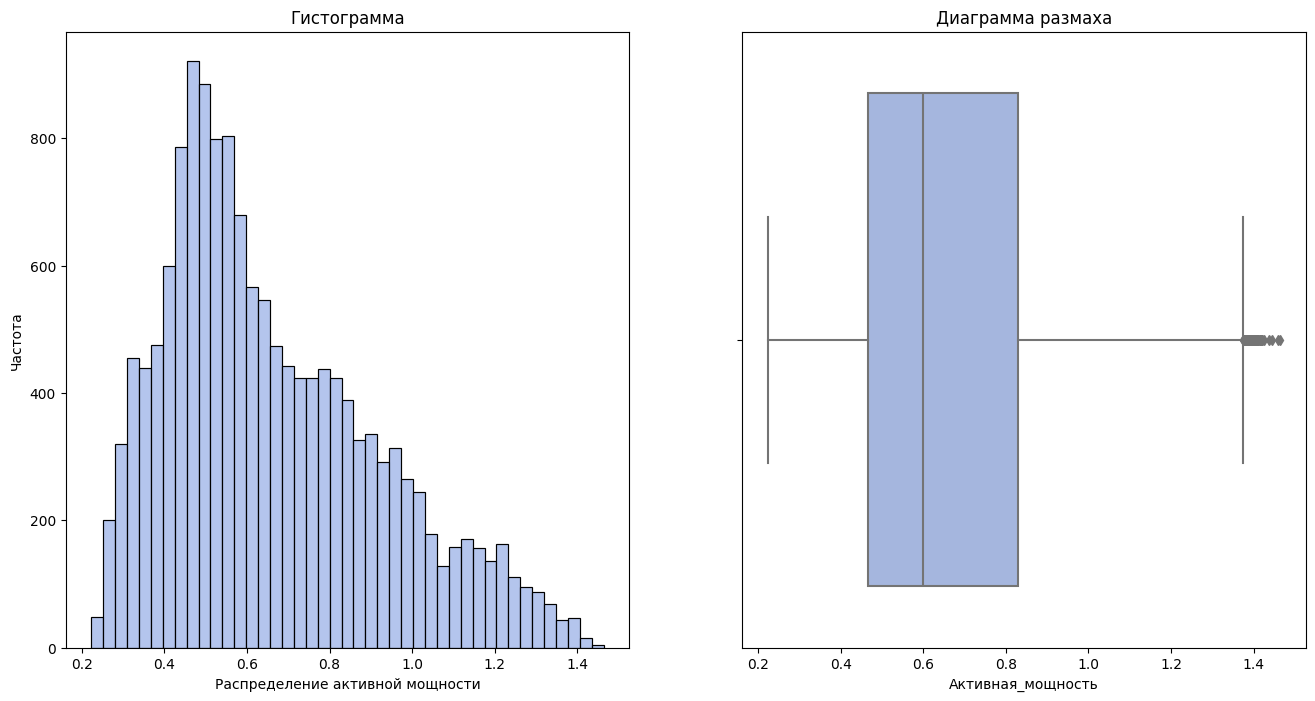

In [69]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = arc, x = 'Активная_мощность', ax=axs[0], color='#9BB2E8')
axs[0].set_xlabel('Распределение активной мощности')
axs[0].set_ylabel('Частота')
axs[0].set_title('Гистограмма')
sns.boxplot(data = arc, x = 'Активная_мощность', ax=axs[1], color='#9BB2E8')
axs[1].set_title('Диаграмма размаха')
plt.show()

C:\Users\peredkova\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


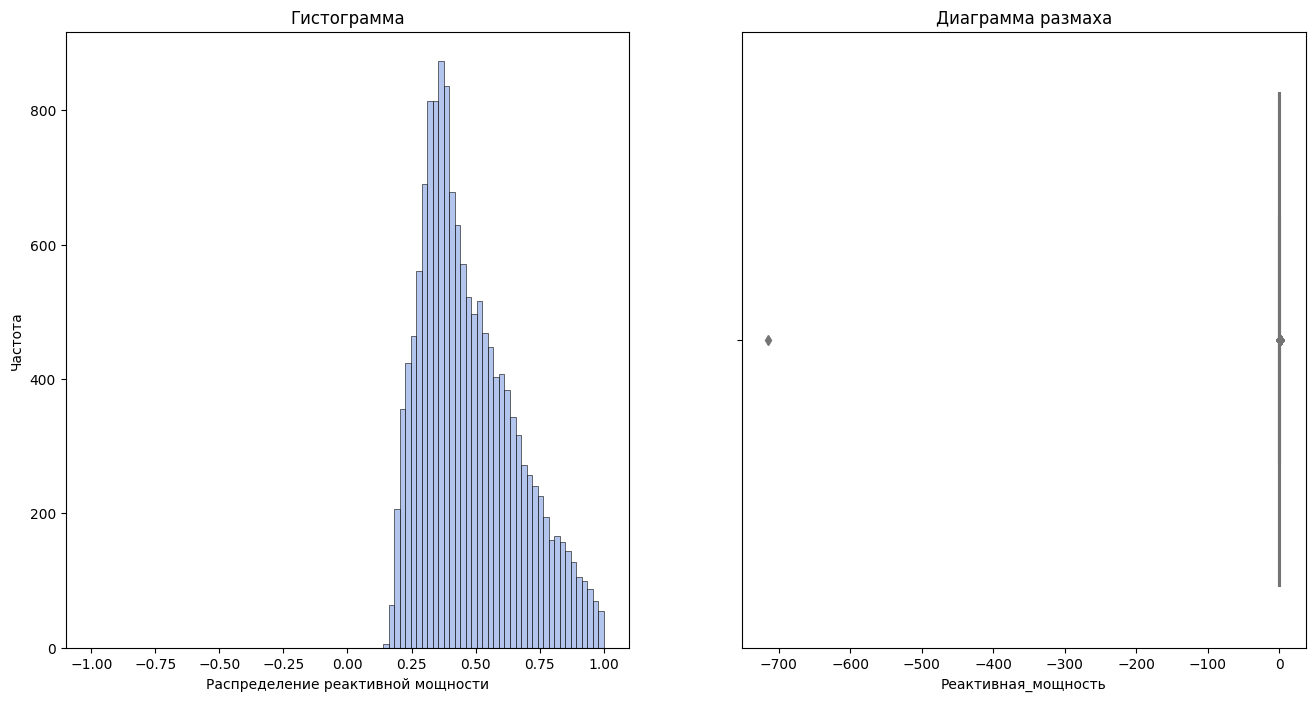

In [70]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = arc, x = 'Реактивная_мощность', ax=axs[0], color='#9BB2E8', binrange=(-1, 1))
axs[0].set_xlabel('Распределение реактивной мощности')
axs[0].set_ylabel('Частота')
axs[0].set_title('Гистограмма')
sns.boxplot(data = arc, x = 'Реактивная_мощность', ax=axs[1], color='#9BB2E8')
axs[1].set_title('Диаграмма размаха')
plt.show()

Мы видим одно аномальное значение: -715, его необходимо удалить, но нам нужно будет удалить не одну эту строку, а весь ковш, сделаем это

In [71]:
int(arc[arc['Реактивная_мощность'] < 0]['key'].values)

C:\Users\peredkova\AppData\Local\Temp\ipykernel_6440\3648314113.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(arc[arc['Реактивная_мощность'] < 0]['key'].values)


2116

In [72]:
arc = arc.where(arc['key'] != int(arc[arc['Реактивная_мощность'] < 0]['key'].values))

C:\Users\peredkova\AppData\Local\Temp\ipykernel_6440\2784529060.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  arc = arc.where(arc['key'] != int(arc[arc['Реактивная_мощность'] < 0]['key'].values))


In [73]:
arc[arc['key'] == 2116]

,key,Начало_нагрева_дугой,Конец_нагрева_дугой,Активная_мощность,Реактивная_мощность


In [74]:
arc['Реактивная_мощность'].describe()

count    14872.000000
mean         0.487112
std          0.197623
min          0.153777
25%          0.337175
50%          0.441667
75%          0.608201
max          1.270284
Name: Реактивная_мощность, dtype: float64

C:\Users\peredkova\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


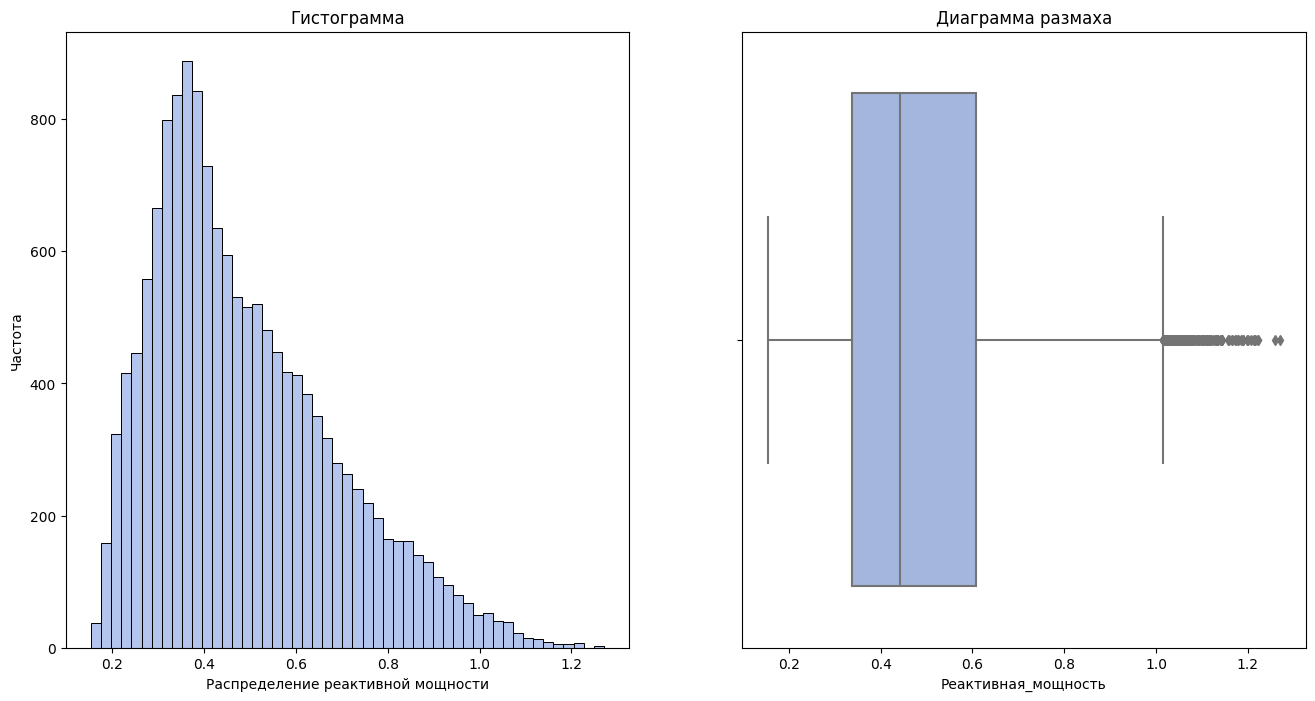

In [75]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = arc, x = 'Реактивная_мощность', ax=axs[0], color='#9BB2E8')
axs[0].set_xlabel('Распределение реактивной мощности')
axs[0].set_ylabel('Частота')
axs[0].set_title('Гистограмма')
sns.boxplot(data = arc, x = 'Реактивная_мощность', ax=axs[1], color='#9BB2E8')
axs[1].set_title('Диаграмма размаха')
plt.show()

**gas**

C:\Users\peredkova\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


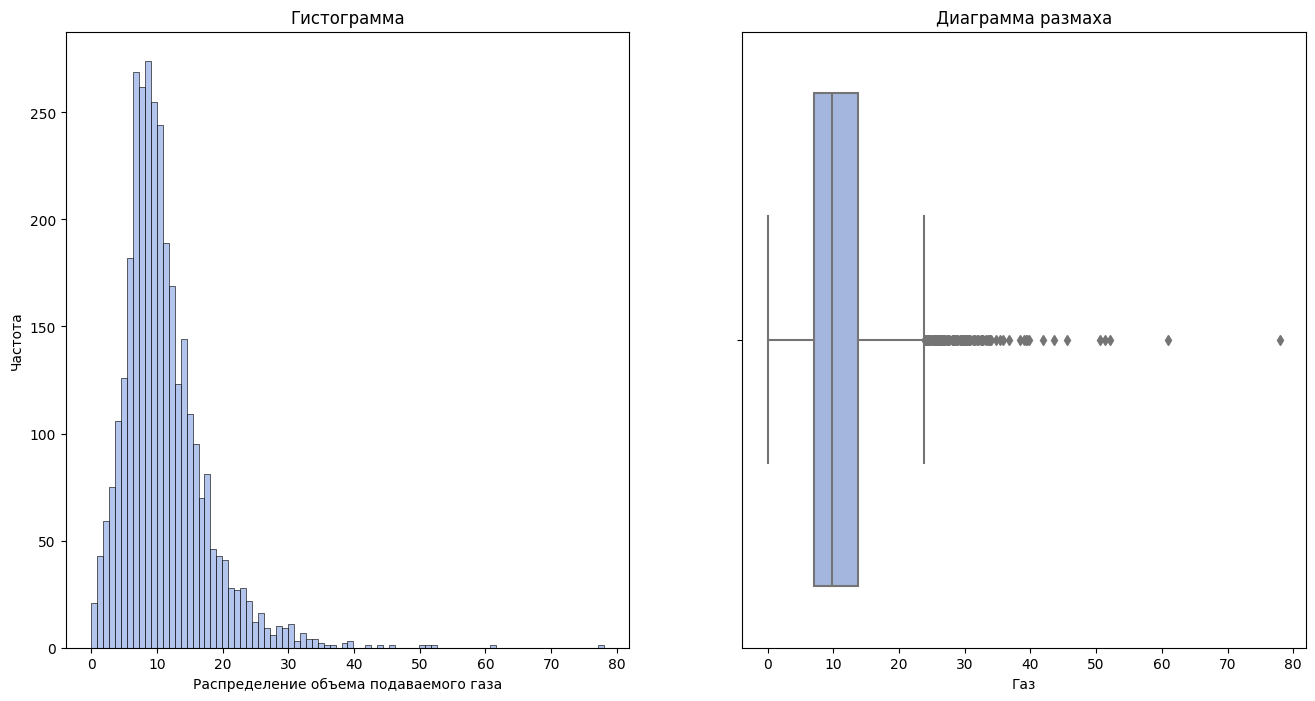

In [76]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = gas, x = 'Газ', ax=axs[0], color='#9BB2E8')
axs[0].set_xlabel('Распределение объема подаваемого газа')
axs[0].set_ylabel('Частота')
axs[0].set_title('Гистограмма')
sns.boxplot(data = gas, x = 'Газ', ax=axs[1], color='#9BB2E8')
axs[1].set_title('Диаграмма размаха')
plt.show()

In [77]:
gas['Газ'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ, dtype: float64

Здесь аномалии обусловлены технологическим процессом

**temperature**

In [78]:
temperature['Температура'].describe()

count    13924.000000
mean      1590.802356
std         19.846423
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: Температура, dtype: float64

C:\Users\peredkova\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


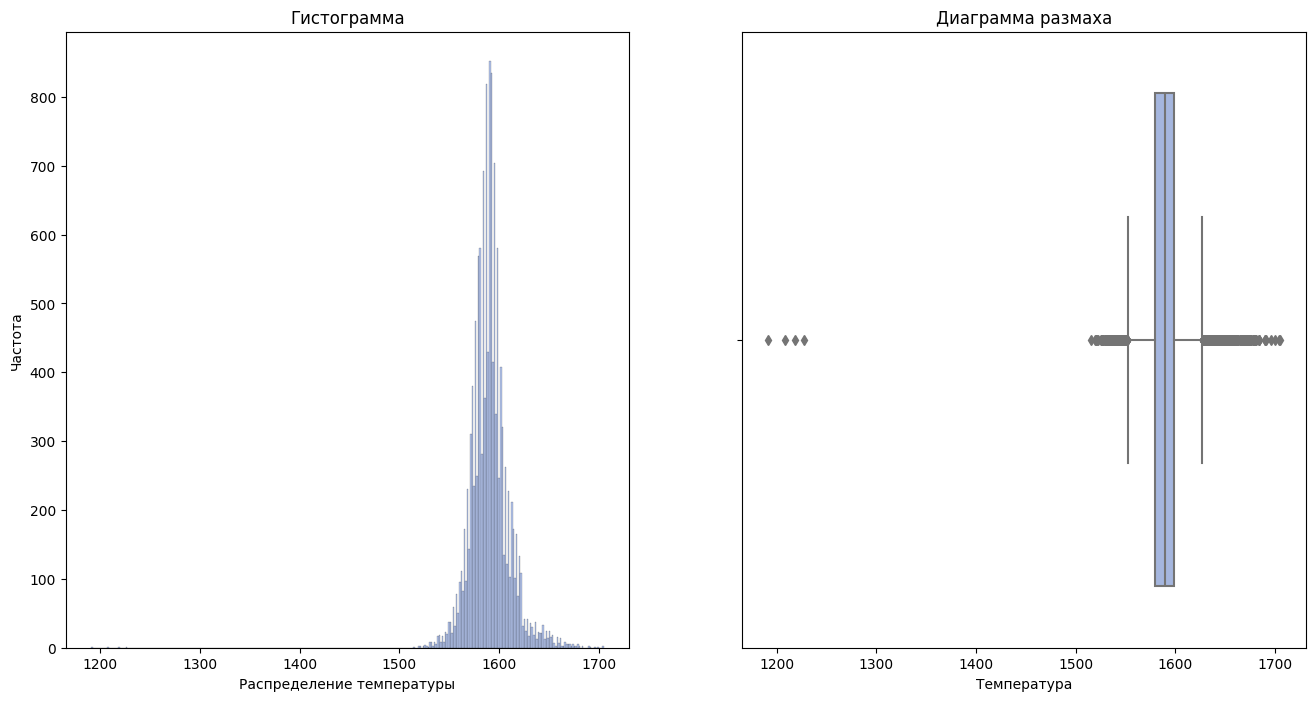

In [79]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = temperature, x = 'Температура', ax=axs[0], color='#9BB2E8')
axs[0].set_xlabel('Распределение температуры')
axs[0].set_ylabel('Частота')
axs[0].set_title('Гистограмма')
sns.boxplot(data = temperature, x = 'Температура', ax=axs[1], color='#9BB2E8')
axs[1].set_title('Диаграмма размаха')
plt.show()

На графике мы видимо несколько значений меньше 1300 градусов, эти данные нужно удалить, так как при такой температуре начинается процесс кристаллизации, заодно будут удалены и пропущенные значения. Опять же будем удалять не строки, а весь ковш

In [80]:
temperature_index_to_drop = temperature[temperature['Температура'] < 1300]['key'].values
temperature_index_to_drop

array([ 867, 1214, 1619, 2052], dtype=int64)

In [81]:
temperature = temperature.query('key not in @temperature_index_to_drop')

In [82]:
temperature_index_to_drop = temperature[temperature['Температура'] < 1300]['key'].values
temperature_index_to_drop

array([], dtype=int64)

C:\Users\peredkova\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


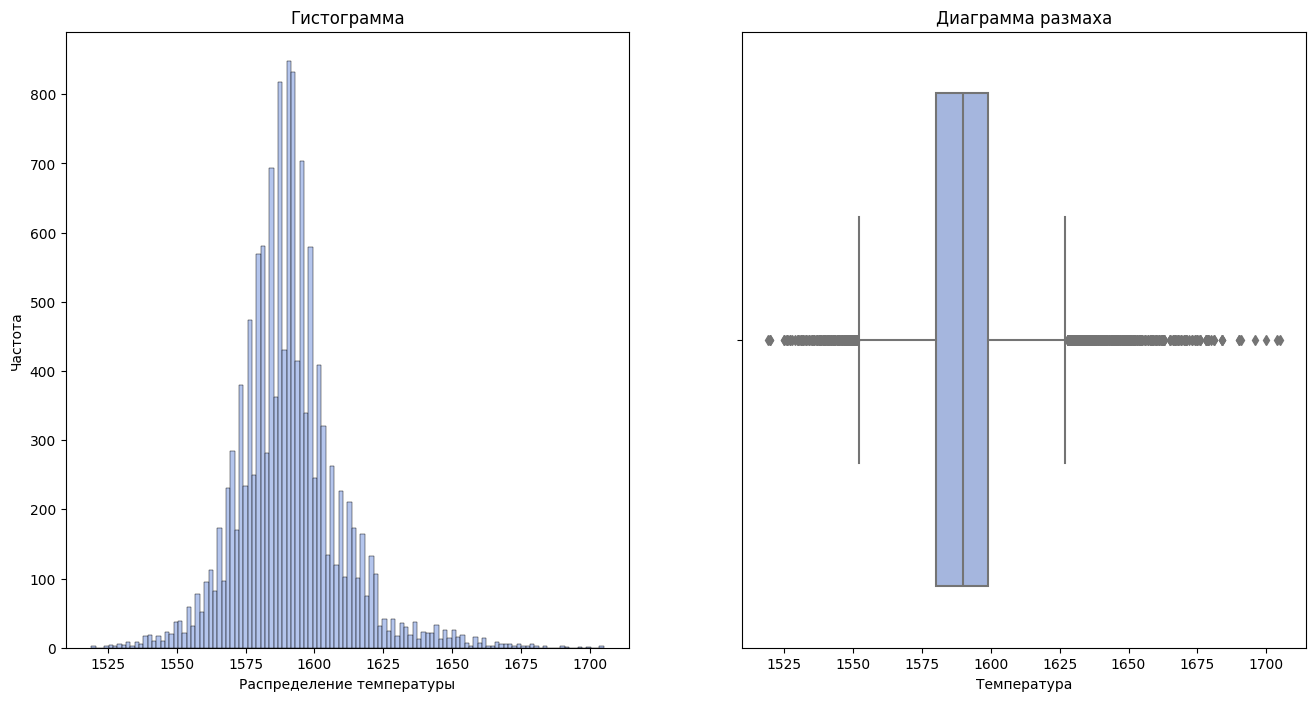

In [83]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = temperature, x = 'Температура', ax=axs[0], color='#9BB2E8')
axs[0].set_xlabel('Распределение температуры')
axs[0].set_ylabel('Частота')
axs[0].set_title('Гистограмма')
sns.boxplot(data = temperature, x = 'Температура', ax=axs[1], color='#9BB2E8')
axs[1].set_title('Диаграмма размаха')
plt.show()

### Создание новых признаков

In [84]:
arc.head(10)

,key,Начало_нагрева_дугой,Конец_нагрева_дугой,Активная_мощность,Реактивная_мощность
0,1.0,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1.0,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1.0,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1.0,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1.0,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2.0,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2.0,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2.0,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2.0,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3.0,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


На основе первого датасета, создадим новые признаки: время нагрева дугой, полная мощность, cosϕ, время нагрева дугой будем измерять в секундах.

In [85]:
arc['Время_нагрева'] = arc['Конец_нагрева_дугой'] - arc['Начало_нагрева_дугой']
arc.head(10)

,key,Начало_нагрева_дугой,Конец_нагрева_дугой,Активная_мощность,Реактивная_мощность,Время_нагрева
0,1.0,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0 days 00:03:48
1,1.0,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0 days 00:03:05
2,1.0,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0 days 00:02:52
3,1.0,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0 days 00:06:05
4,1.0,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0 days 00:02:28
5,2.0,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,0 days 00:02:17
6,2.0,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,0 days 00:05:38
7,2.0,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,0 days 00:02:06
8,2.0,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,0 days 00:03:30
9,3.0,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,0 days 00:04:40


In [86]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   key                   14872 non-null  float64        
 1   Начало_нагрева_дугой  14872 non-null  datetime64[ns] 
 2   Конец_нагрева_дугой   14872 non-null  datetime64[ns] 
 3   Активная_мощность     14872 non-null  float64        
 4   Реактивная_мощность   14872 non-null  float64        
 5   Время_нагрева         14872 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), float64(3), timedelta64[ns](1)
memory usage: 697.4 KB


In [87]:
arc['Время_нагрева'] = arc['Время_нагрева'].dt.total_seconds()
arc.head(10)

,key,Начало_нагрева_дугой,Конец_нагрева_дугой,Активная_мощность,Реактивная_мощность,Время_нагрева
0,1.0,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0
1,1.0,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0
2,1.0,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0
3,1.0,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0
4,1.0,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0
5,2.0,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,137.0
6,2.0,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,338.0
7,2.0,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,126.0
8,2.0,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,210.0
9,3.0,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,280.0


Полная мощность вычисляется по формуле  S = √(P² + Q²), где S — полная мощность, P — активная мощность, Q — реактивная мощность.

In [88]:
arc['Полная_мощность'] =  (arc['Активная_мощность']**2 + arc['Реактивная_мощность']**2)**(0.5)

In [89]:
arc['Косинус_фи'] = arc['Активная_мощность'] / arc['Полная_мощность']

In [90]:
arc.head(5)

,key,Начало_нагрева_дугой,Конец_нагрева_дугой,Активная_мощность,Реактивная_мощность,Время_нагрева,Полная_мощность,Косинус_фи
0,1.0,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123,0.822181
1,1.0,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319,0.848545
2,1.0,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536,0.803161
3,1.0,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824,0.806591
4,1.0,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934,0.802950


Новые признаки добавлены

## Объединение данных

Объединять данные будем по ключу `key`, при этом в итоговом датасете должны остаться те номера партий, которые есть во всех датасетах. 

В датасетах `arc` и `temperature` один и тот же номер партии встречается несколько раз, в итоговом датасете каждая строка должна соответствовать одному номеру партии. Поэтому сгруппируем эти датасеты по номеру партии в возьмем среднее значение. Я считаю, что лучше брать среднее значение, а не сумму, потому что получатся не очень логичные значения с точки зрения физики. Например, косинус фи больше 1 быть не может. 

Разберемся с датасетом `arc`

In [91]:
arc.head(10)

,key,Начало_нагрева_дугой,Конец_нагрева_дугой,Активная_мощность,Реактивная_мощность,Время_нагрева,Полная_мощность,Косинус_фи
0,1.0,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123,0.822181
1,1.0,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319,0.848545
2,1.0,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536,0.803161
3,1.0,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824,0.806591
4,1.0,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934,0.802950
5,2.0,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,137.0,0.440239,0.865721
6,2.0,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,338.0,0.332731,0.786416
7,2.0,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,126.0,0.860064,0.825865
8,2.0,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,210.0,0.955315,0.823102
9,3.0,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,280.0,1.373863,0.801884


Перед объединением данных добавим новый признак - количество плавок

In [92]:
fdgf = arc.groupby('key')['Активная_мощность'].count()

In [93]:
count_key = pd.DataFrame(arc.groupby('key')['Активная_мощность'].count()).reset_index()
count_key.columns = ['key', 'count_key']
count_key.head()

,key,count_key
0,1.0,5
1,2.0,4
2,3.0,5
3,4.0,4
4,5.0,4


In [94]:
result_arc = arc.pivot_table(index='key', values = ['Активная_мощность', 
                                                   'Реактивная_мощность', 
                                                   'Время_нагрева', 
                                                   'Полная_мощность', 'Косинус_фи'], aggfunc='sum')

In [95]:
result_arc.head(10)

,Активная_мощность,Время_нагрева,Косинус_фи,Полная_мощность,Реактивная_мощность
key,,,,,
1.0,3.036730,1098.0,4.083428,3.718736,2.142821
2.0,2.139408,811.0,3.301105,2.588349,1.453357
3.0,4.063641,655.0,4.048621,5.019223,2.937457
4.0,2.706489,741.0,3.175691,3.400038,2.056992
5.0,2.252950,869.0,3.187274,2.816980,1.687991
6.0,2.725274,952.0,3.269041,3.313074,1.881313
7.0,2.626877,673.0,3.209965,3.283913,1.960419
8.0,2.678958,913.0,3.197157,3.405956,2.096952
9.0,3.520820,625.0,4.066417,4.335261,2.527365


In [96]:
result_arc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3213 entries, 1.0 to 3241.0
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Активная_мощность    3213 non-null   float64
 1   Время_нагрева        3213 non-null   float64
 2   Косинус_фи           3213 non-null   float64
 3   Полная_мощность      3213 non-null   float64
 4   Реактивная_мощность  3213 non-null   float64
dtypes: float64(5)
memory usage: 150.6 KB


В итоговом столбце осталось 3214 значений номеров партии, так же удалились столбцы `Начало_нагрева_дугой` и `Конец_нагрева_дугой`, для работы модели они нам не понадобятся, мы создали новый признак на основне этих данных.

In [97]:
temperature.head(10)

,key,Время_замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [98]:
temperature.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13903 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13903 non-null  int64         
 1   Время_замера  13903 non-null  datetime64[ns]
 2   Температура   13903 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 434.5 KB


В итоговом датасете нам пригодятся еще два признака: Начальная температура нагрева и Максимальная температура нагрева. Выделим эти данные и поместим в отдельные столбцы

In [99]:
result_temperature = temperature.pivot_table(index='key', values = ['Температура'], aggfunc=['first', 'last'])
result_temperature.columns=['Начальная_температура', 'Температура']

In [100]:
result_temperature.head(10)

,Начальная_температура,Температура
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
6,1543.0,1596.0
7,1586.0,1599.0
8,1577.0,1598.0
9,1587.0,1592.0


In [101]:
result_temperature.tail(10)

,Начальная_температура,Температура
key,,
2489,1613.0,1579.0
2490,1602.0,1619.0
2492,1618.0,1595.0
2493,1599.0,1594.0
2494,1585.0,1591.0
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0
2498,1591.0,1594.0


In [102]:
result_temperature.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2471 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Начальная_температура  2471 non-null   float64
 1   Температура            2471 non-null   float64
dtypes: float64(2)
memory usage: 57.9 KB


В датасете осталось 3215 уникальных значений номер партии, на один больше, чем в предыдущем датасете. Теперь можем приступать объединению датасетов.

In [103]:
result_arc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3213 entries, 1.0 to 3241.0
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Активная_мощность    3213 non-null   float64
 1   Время_нагрева        3213 non-null   float64
 2   Косинус_фи           3213 non-null   float64
 3   Полная_мощность      3213 non-null   float64
 4   Реактивная_мощность  3213 non-null   float64
dtypes: float64(5)
memory usage: 150.6 KB


In [104]:
bulk_volume.head()

,key,Bulk_volume_1,Bulk_volume_2,Bulk_volume_3,Bulk_volume_4,Bulk_volume_5,Bulk_volume_6,Bulk_volume_7,Bulk_volume_8,Bulk_volume_9,Bulk_volume_10,Bulk_volume_11,Bulk_volume_12,Bulk_volume_13,Bulk_volume_14,Bulk_volume_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [105]:
result_arc = result_arc.reset_index()
result_arc

,key,Активная_мощность,Время_нагрева,Косинус_фи,Полная_мощность,Реактивная_мощность
0,1.0,3.036730,1098.0,4.083428,3.718736,2.142821
1,2.0,2.139408,811.0,3.301105,2.588349,1.453357
2,3.0,4.063641,655.0,4.048621,5.019223,2.937457
3,4.0,2.706489,741.0,3.175691,3.400038,2.056992
4,5.0,2.252950,869.0,3.187274,2.816980,1.687991
...,...,...,...,...,...,...
3208,3237.0,2.541872,909.0,3.915487,3.250657,2.025417
3209,3238.0,1.374821,546.0,2.391324,1.723937,1.038103
3210,3239.0,4.848005,1216.0,6.413809,6.014480,3.541541
3211,3240.0,3.317679,839.0,4.071563,4.082920,2.373552


In [106]:
result_temperature = result_temperature.reset_index()
result_temperature.head(5)

,key,Начальная_температура,Температура
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


In [107]:
result = pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(result_arc, bulk_volume, on='key', how='inner'), bulk_time, on='key', how='inner'), gas, on='key', how='inner'), wire_volume, on='key', how='inner'), wire_time, on='key', how='inner'), count_key, on='key', how='inner'), result_temperature, on='key', how='inner')
result.head()

,key,Активная_мощность,Время_нагрева,Косинус_фи,Полная_мощность,Реактивная_мощность,Bulk_volume_1,Bulk_volume_2,Bulk_volume_3,Bulk_volume_4,Bulk_volume_5,Bulk_volume_6,Bulk_volume_7,Bulk_volume_8,Bulk_volume_9,Bulk_volume_10,Bulk_volume_11,Bulk_volume_12,Bulk_volume_13,Bulk_volume_14,Bulk_volume_15,Bulk_time_1,Bulk_time_2,Bulk_time_3,Bulk_time_4,Bulk_time_5,Bulk_time_6,Bulk_time_7,Bulk_time_8,Bulk_time_9,Bulk_time_10,Bulk_time_11,Bulk_time_12,Bulk_time_13,Bulk_time_14,Bulk_time_15,Газ,Wire_volume_1,Wire_volume_2,Wire_volume_3,Wire_volume_4,Wire_volume_5,Wire_volume_6,Wire_volume_7,Wire_volume_8,Wire_volume_9,Wire_time_1,Wire_time_2,Wire_time_3,Wire_time_4,Wire_time_5,Wire_time_6,Wire_time_7,Wire_time_8,Wire_time_9,count_key,Начальная_температура,Температура
0,1.0,3.036730,1098.0,4.083428,3.718736,2.142821,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,0,0,0,2019-05-03 11:28:48,0,0,0,0,0,0,0,2019-05-03 11:24:31,0,2019-05-03 11:14:50,2019-05-03 11:10:43,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:06:19,0,0,0,0,0,0,0,0,5,1571.0,1613.0
1,2.0,2.139408,811.0,3.301105,2.588349,1.453357,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,0,0,0,2019-05-03 11:36:50,0,0,0,0,0,0,0,2019-05-03 11:53:30,0,2019-05-03 11:48:37,2019-05-03 11:44:39,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:36:50,0,0,0,0,0,0,0,0,4,1581.0,1602.0
2,3.0,4.063641,655.0,4.048621,5.019223,2.937457,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,0,0,0,2019-05-03 12:32:39,0,0,0,0,0,0,0,2019-05-03 12:27:13,0,2019-05-03 12:21:01,2019-05-03 12:16:16,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:11:46,0,0,0,0,0,0,0,0,5,1596.0,1599.0
3,4.0,2.706489,741.0,3.175691,3.400038,2.056992,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,0,0,0,2019-05-03 12:43:22,0,0,0,0,0,0,0,2019-05-03 12:58:00,0,2019-05-03 12:51:11,2019-05-03 12:46:36,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:43:22,0,0,0,0,0,0,0,0,4,1601.0,1625.0
4,5.0,2.252950,869.0,3.187274,2.816980,1.687991,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,0,0,0,2019-05-03 13:30:47,0,0,0,0,0,0,0,2019-05-03 13:30:47,0,2019-05-03 13:34:12,2019-05-03 13:30:47,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 13:20:44,2019-05-03 13:15:34,0,0,0,0,0,0,0,4,1576.0,1602.0


In [108]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 58 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2324 non-null   float64
 1   Активная_мощность      2324 non-null   float64
 2   Время_нагрева          2324 non-null   float64
 3   Косинус_фи             2324 non-null   float64
 4   Полная_мощность        2324 non-null   float64
 5   Реактивная_мощность    2324 non-null   float64
 6   Bulk_volume_1          2324 non-null   float64
 7   Bulk_volume_2          2324 non-null   float64
 8   Bulk_volume_3          2324 non-null   float64
 9   Bulk_volume_4          2324 non-null   float64
 10  Bulk_volume_5          2324 non-null   float64
 11  Bulk_volume_6          2324 non-null   float64
 12  Bulk_volume_7          2324 non-null   float64
 13  Bulk_volume_8          2324 non-null   float64
 14  Bulk_volume_9          2324 non-null   float64
 15  Bulk

## Исследовательский анализ и предобработка объединенных датафреймов 

### Добавление новых признаков

In [109]:
result.columns

Index(['key', 'Активная_мощность', 'Время_нагрева', 'Косинус_фи',
       'Полная_мощность', 'Реактивная_мощность', 'Bulk_volume_1',
       'Bulk_volume_2', 'Bulk_volume_3', 'Bulk_volume_4', 'Bulk_volume_5',
       'Bulk_volume_6', 'Bulk_volume_7', 'Bulk_volume_8', 'Bulk_volume_9',
       'Bulk_volume_10', 'Bulk_volume_11', 'Bulk_volume_12', 'Bulk_volume_13',
       'Bulk_volume_14', 'Bulk_volume_15', 'Bulk_time_1', 'Bulk_time_2',
       'Bulk_time_3', 'Bulk_time_4', 'Bulk_time_5', 'Bulk_time_6',
       'Bulk_time_7', 'Bulk_time_8', 'Bulk_time_9', 'Bulk_time_10',
       'Bulk_time_11', 'Bulk_time_12', 'Bulk_time_13', 'Bulk_time_14',
       'Bulk_time_15', 'Газ', 'Wire_volume_1', 'Wire_volume_2',
       'Wire_volume_3', 'Wire_volume_4', 'Wire_volume_5', 'Wire_volume_6',
       'Wire_volume_7', 'Wire_volume_8', 'Wire_volume_9', 'Wire_time_1',
       'Wire_time_2', 'Wire_time_3', 'Wire_time_4', 'Wire_time_5',
       'Wire_time_6', 'Wire_time_7', 'Wire_time_8', 'Wire_time_9', 'count_key',
 

Сумма присадок Bulk

In [110]:
result['Bulk_sum'] = result['Bulk_volume_1'] + result['Bulk_volume_2'] + result['Bulk_volume_3'] + result['Bulk_volume_4'] + result['Bulk_volume_5'] + result['Bulk_volume_6'] + result['Bulk_volume_7'] + result['Bulk_volume_8'] + result['Bulk_volume_9'] + result['Bulk_volume_10'] + result['Bulk_volume_11'] + result['Bulk_volume_12'] + result['Bulk_volume_13'] + result['Bulk_volume_14'] + result['Bulk_volume_15']

Сумма проволочных присадок

In [111]:
result['Wire_sum'] = result['Wire_volume_1'] + result['Wire_volume_2'] + result['Wire_volume_3'] + result['Wire_volume_4'] + result['Wire_volume_5'] + result['Wire_volume_6'] + result['Wire_volume_7'] + result['Wire_volume_8'] + result['Wire_volume_9']

Удалим все столбцы со временем, они не пригодятся для обучения модели

In [112]:
result = result.drop(['Bulk_time_1', 'Bulk_time_2','Bulk_time_3', 'Bulk_time_4', 'Bulk_time_5', 'Bulk_time_6','Bulk_time_7', 'Bulk_time_8', 'Bulk_time_9', 'Bulk_time_10','Bulk_time_11', 'Bulk_time_12', 'Bulk_time_13', 'Bulk_time_14','Bulk_time_15', 'Wire_time_1','Wire_time_2', 'Wire_time_3', 'Wire_time_4', 'Wire_time_5','Wire_time_6', 'Wire_time_7', 'Wire_time_8', 'Wire_time_9'], axis=1)

Максимальное значение среди всех столбцов Bulk

In [113]:
result['max_bulk'] = result[['Bulk_volume_1', 'Bulk_volume_2', 'Bulk_volume_3', 'Bulk_volume_4', 'Bulk_volume_5', 'Bulk_volume_6', 'Bulk_volume_7', 'Bulk_volume_8', 'Bulk_volume_9', 'Bulk_volume_10', 'Bulk_volume_11', 'Bulk_volume_12', 'Bulk_volume_13', 'Bulk_volume_14', 'Bulk_volume_15']].max(axis=1)

Максимальное значение среди всех столбцов Wire

In [114]:
result['max_wire'] = result[['Wire_volume_1', 'Wire_volume_2','Wire_volume_3', 'Wire_volume_4', 'Wire_volume_5', 'Wire_volume_6', 'Wire_volume_7', 'Wire_volume_8', 'Wire_volume_9']].max(axis=1)

Количество ненулевых значений в столбцах Bulk

In [115]:
result['not_null_bulk'] = result[['Bulk_volume_1', 'Bulk_volume_2', 'Bulk_volume_3', 'Bulk_volume_4', 'Bulk_volume_5', 'Bulk_volume_6', 'Bulk_volume_7', 'Bulk_volume_8', 'Bulk_volume_9', 'Bulk_volume_10', 'Bulk_volume_11', 'Bulk_volume_12', 'Bulk_volume_13', 'Bulk_volume_14', 'Bulk_volume_15']].ne(0).sum(axis=1)

Количество ненулевых значений в столбцах Wire

In [116]:
result['not_null_wire'] = result[['Wire_volume_1', 'Wire_volume_2','Wire_volume_3', 'Wire_volume_4', 'Wire_volume_5', 'Wire_volume_6', 'Wire_volume_7', 'Wire_volume_8', 'Wire_volume_9']].ne(0).sum(axis=1)

Активная энергия

In [117]:
result['actice_energy'] = result['Активная_мощность'] * result['Время_нагрева']

Реактивная энергия

In [118]:
result['reactice_energy'] = result['Реактивная_мощность'] * result['Время_нагрева']

In [119]:
result.head(5)

,key,Активная_мощность,Время_нагрева,Косинус_фи,Полная_мощность,Реактивная_мощность,Bulk_volume_1,Bulk_volume_2,Bulk_volume_3,Bulk_volume_4,Bulk_volume_5,Bulk_volume_6,Bulk_volume_7,Bulk_volume_8,Bulk_volume_9,Bulk_volume_10,Bulk_volume_11,Bulk_volume_12,Bulk_volume_13,Bulk_volume_14,Bulk_volume_15,Газ,Wire_volume_1,Wire_volume_2,Wire_volume_3,Wire_volume_4,Wire_volume_5,Wire_volume_6,Wire_volume_7,Wire_volume_8,Wire_volume_9,count_key,Начальная_температура,Температура,Bulk_sum,Wire_sum,max_bulk,max_wire,not_null_bulk,not_null_wire,actice_energy,reactice_energy
0,1.0,3.036730,1098.0,4.083428,3.718736,2.142821,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1571.0,1613.0,553.0,60.059998,206.0,60.059998,4,1,3334.329540,2352.817458
1,2.0,2.139408,811.0,3.301105,2.588349,1.453357,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1581.0,1602.0,582.0,96.052315,206.0,96.052315,4,1,1735.059888,1178.672527
2,3.0,4.063641,655.0,4.048621,5.019223,2.937457,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1596.0,1599.0,544.0,91.160157,205.0,91.160157,4,1,2661.684855,1924.034335
3,4.0,2.706489,741.0,3.175691,3.400038,2.056992,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1601.0,1625.0,595.0,89.063515,207.0,89.063515,4,1,2005.508349,1524.231072
4,5.0,2.252950,869.0,3.187274,2.816980,1.687991,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1576.0,1602.0,584.0,98.352796,203.0,89.238236,4,2,1957.813550,1466.864179


In [120]:
result['sqr_time'] = result['Bulk_volume_4']**2

In [121]:
result.columns

Index(['key', 'Активная_мощность', 'Время_нагрева', 'Косинус_фи',
       'Полная_мощность', 'Реактивная_мощность', 'Bulk_volume_1',
       'Bulk_volume_2', 'Bulk_volume_3', 'Bulk_volume_4', 'Bulk_volume_5',
       'Bulk_volume_6', 'Bulk_volume_7', 'Bulk_volume_8', 'Bulk_volume_9',
       'Bulk_volume_10', 'Bulk_volume_11', 'Bulk_volume_12', 'Bulk_volume_13',
       'Bulk_volume_14', 'Bulk_volume_15', 'Газ', 'Wire_volume_1',
       'Wire_volume_2', 'Wire_volume_3', 'Wire_volume_4', 'Wire_volume_5',
       'Wire_volume_6', 'Wire_volume_7', 'Wire_volume_8', 'Wire_volume_9',
       'count_key', 'Начальная_температура', 'Температура', 'Bulk_sum',
       'Wire_sum', 'max_bulk', 'max_wire', 'not_null_bulk', 'not_null_wire',
       'actice_energy', 'reactice_energy', 'sqr_time'],
      dtype='object')

Построим график зависимости целевого признака от остальных признаков

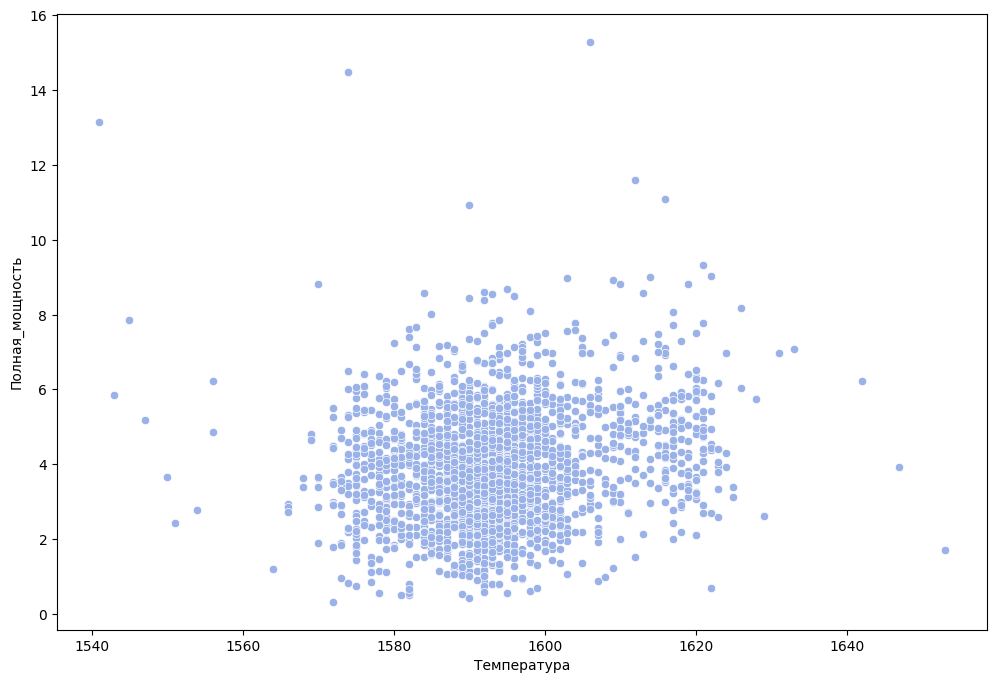

In [122]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Температура', y='Полная_мощность', data=result, color='#9BB2E8')
plt.show()

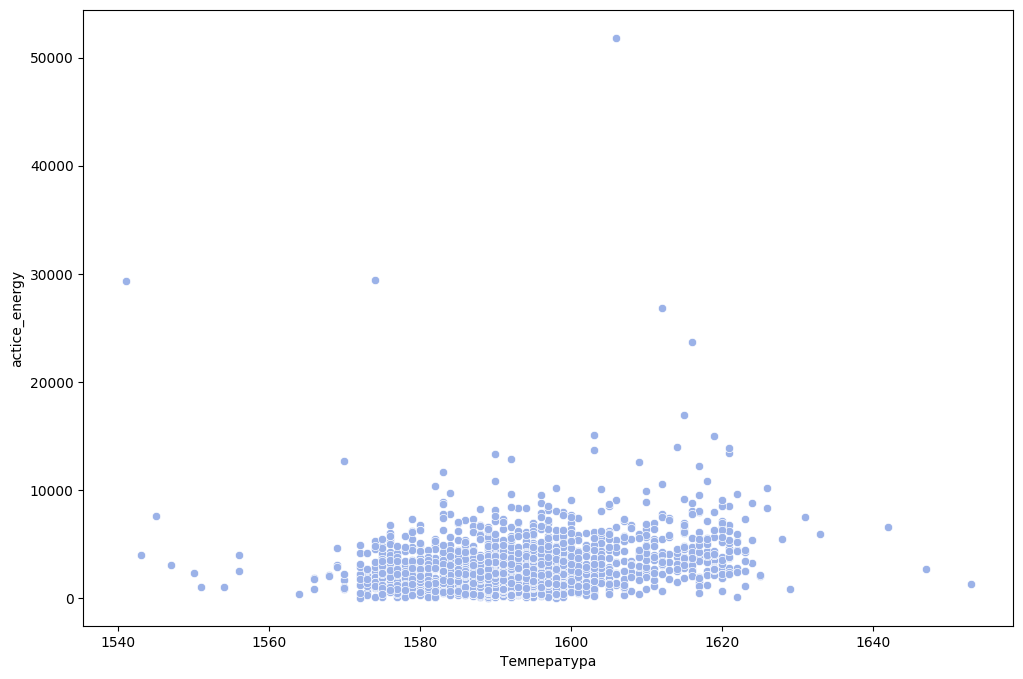

In [123]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Температура', y='actice_energy', data=result, color='#9BB2E8')
plt.show()

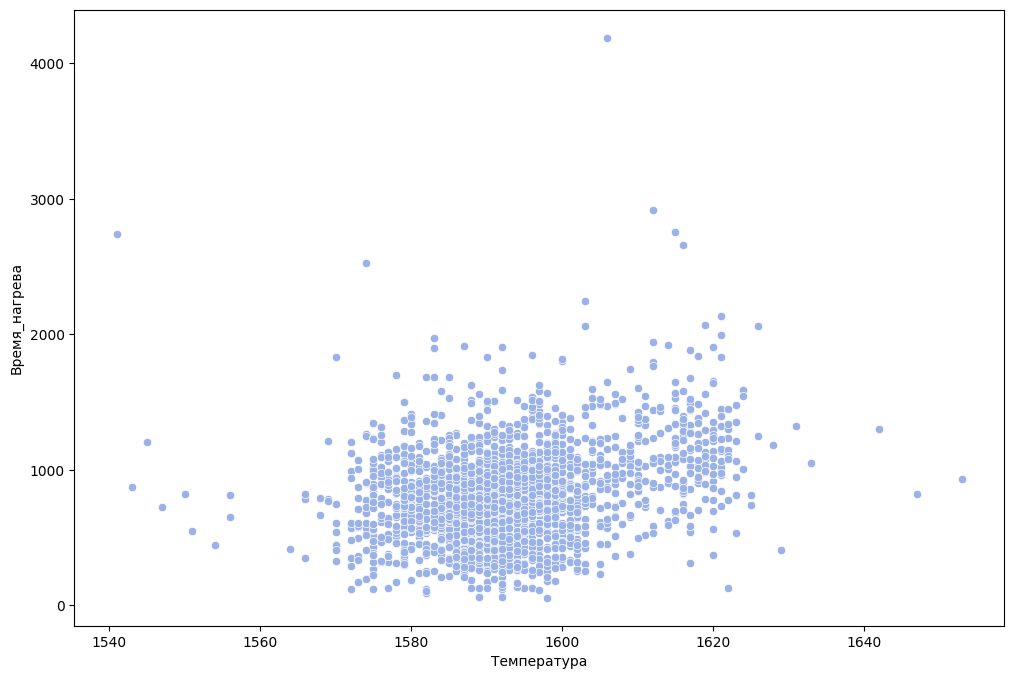

In [124]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Температура', y='Время_нагрева', data=result, color='#9BB2E8')
plt.show()

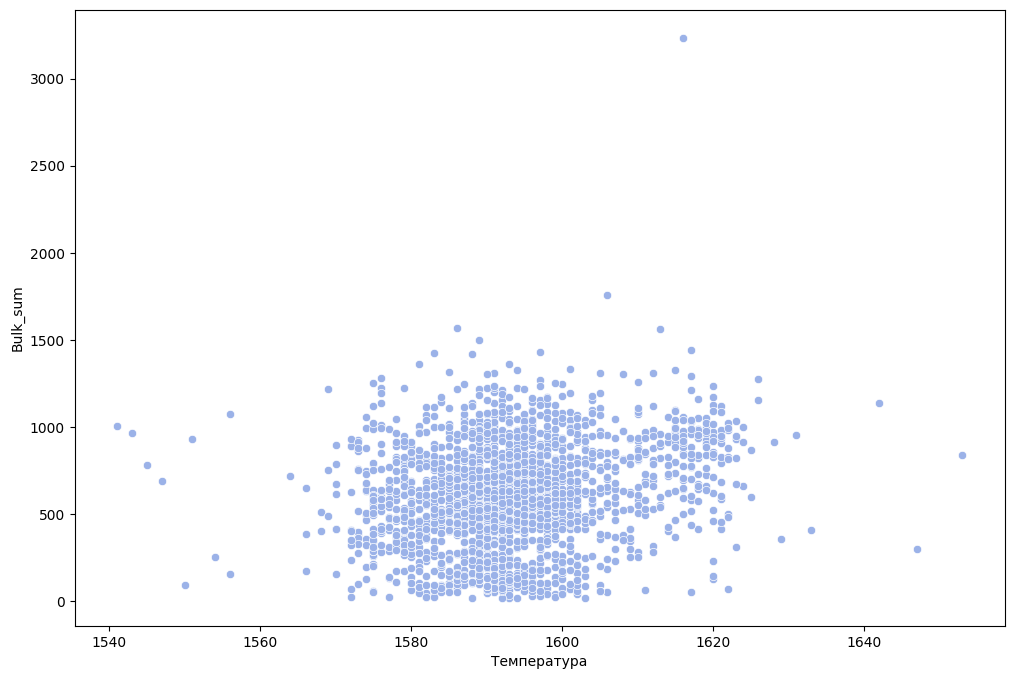

In [125]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Температура', y='Bulk_sum', data=result, color='#9BB2E8')
plt.show()

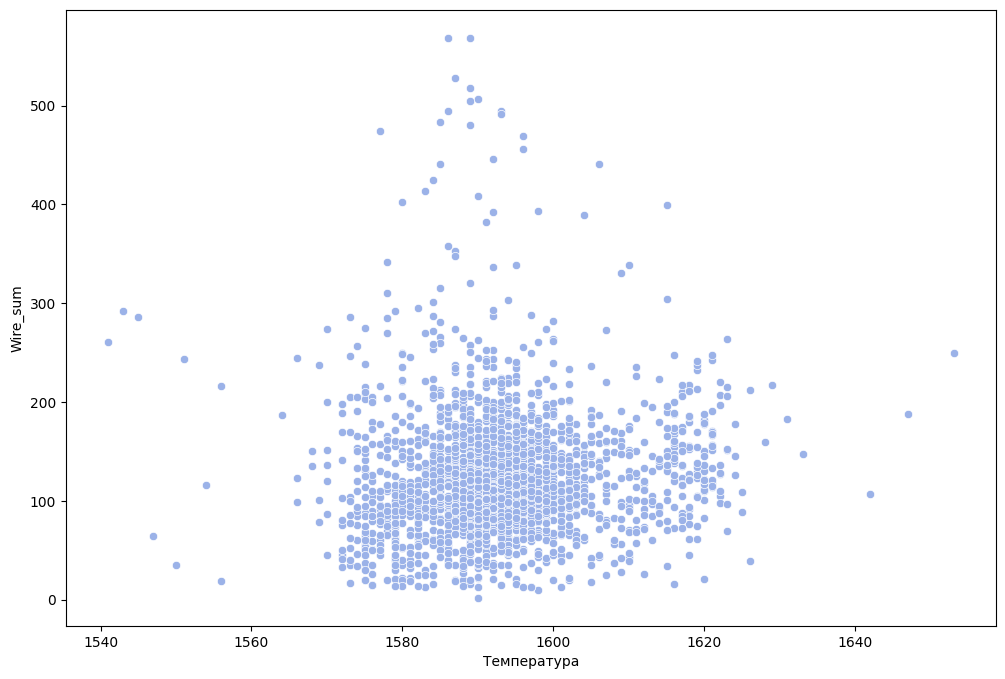

In [126]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Температура', y='Wire_sum', data=result, color='#9BB2E8')
plt.show()

Зависимости нелинейные

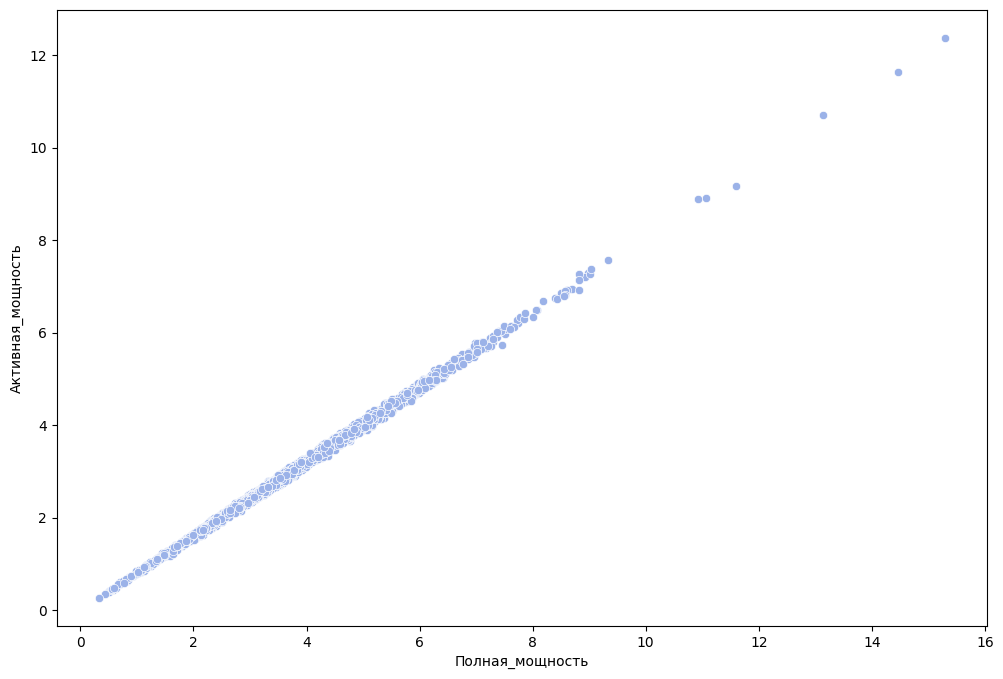

In [127]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Полная_мощность', y='Активная_мощность', data=result, color='#9BB2E8')
plt.show()

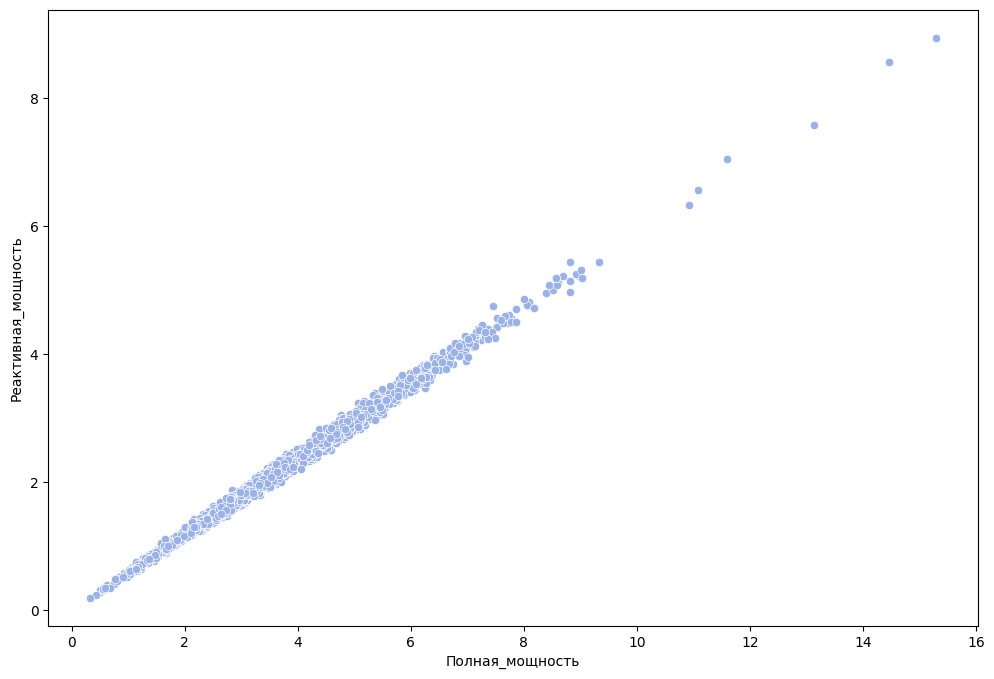

In [128]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Полная_мощность', y='Реактивная_мощность', data=result, color='#9BB2E8')
plt.show()

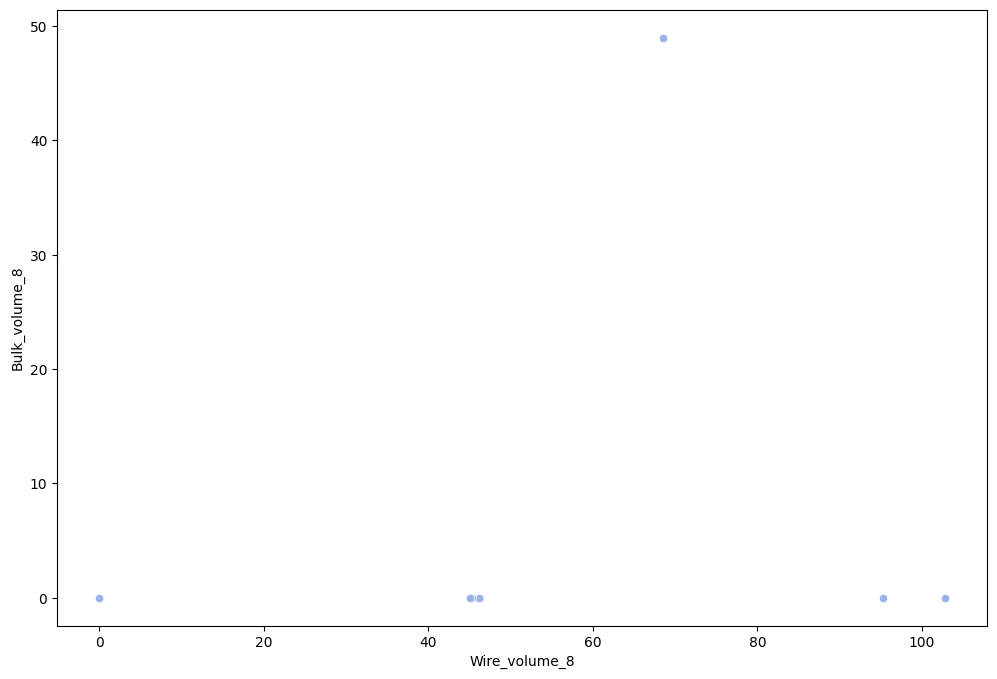

In [129]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Wire_volume_8', y='Bulk_volume_8', data=result, color='#9BB2E8')
plt.show()

Построим матрицу корреляции

C:\Users\peredkova\AppData\Local\anaconda3\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable Wire_volume_5 for analysis 1. Dropping this column
  warnings.warn(


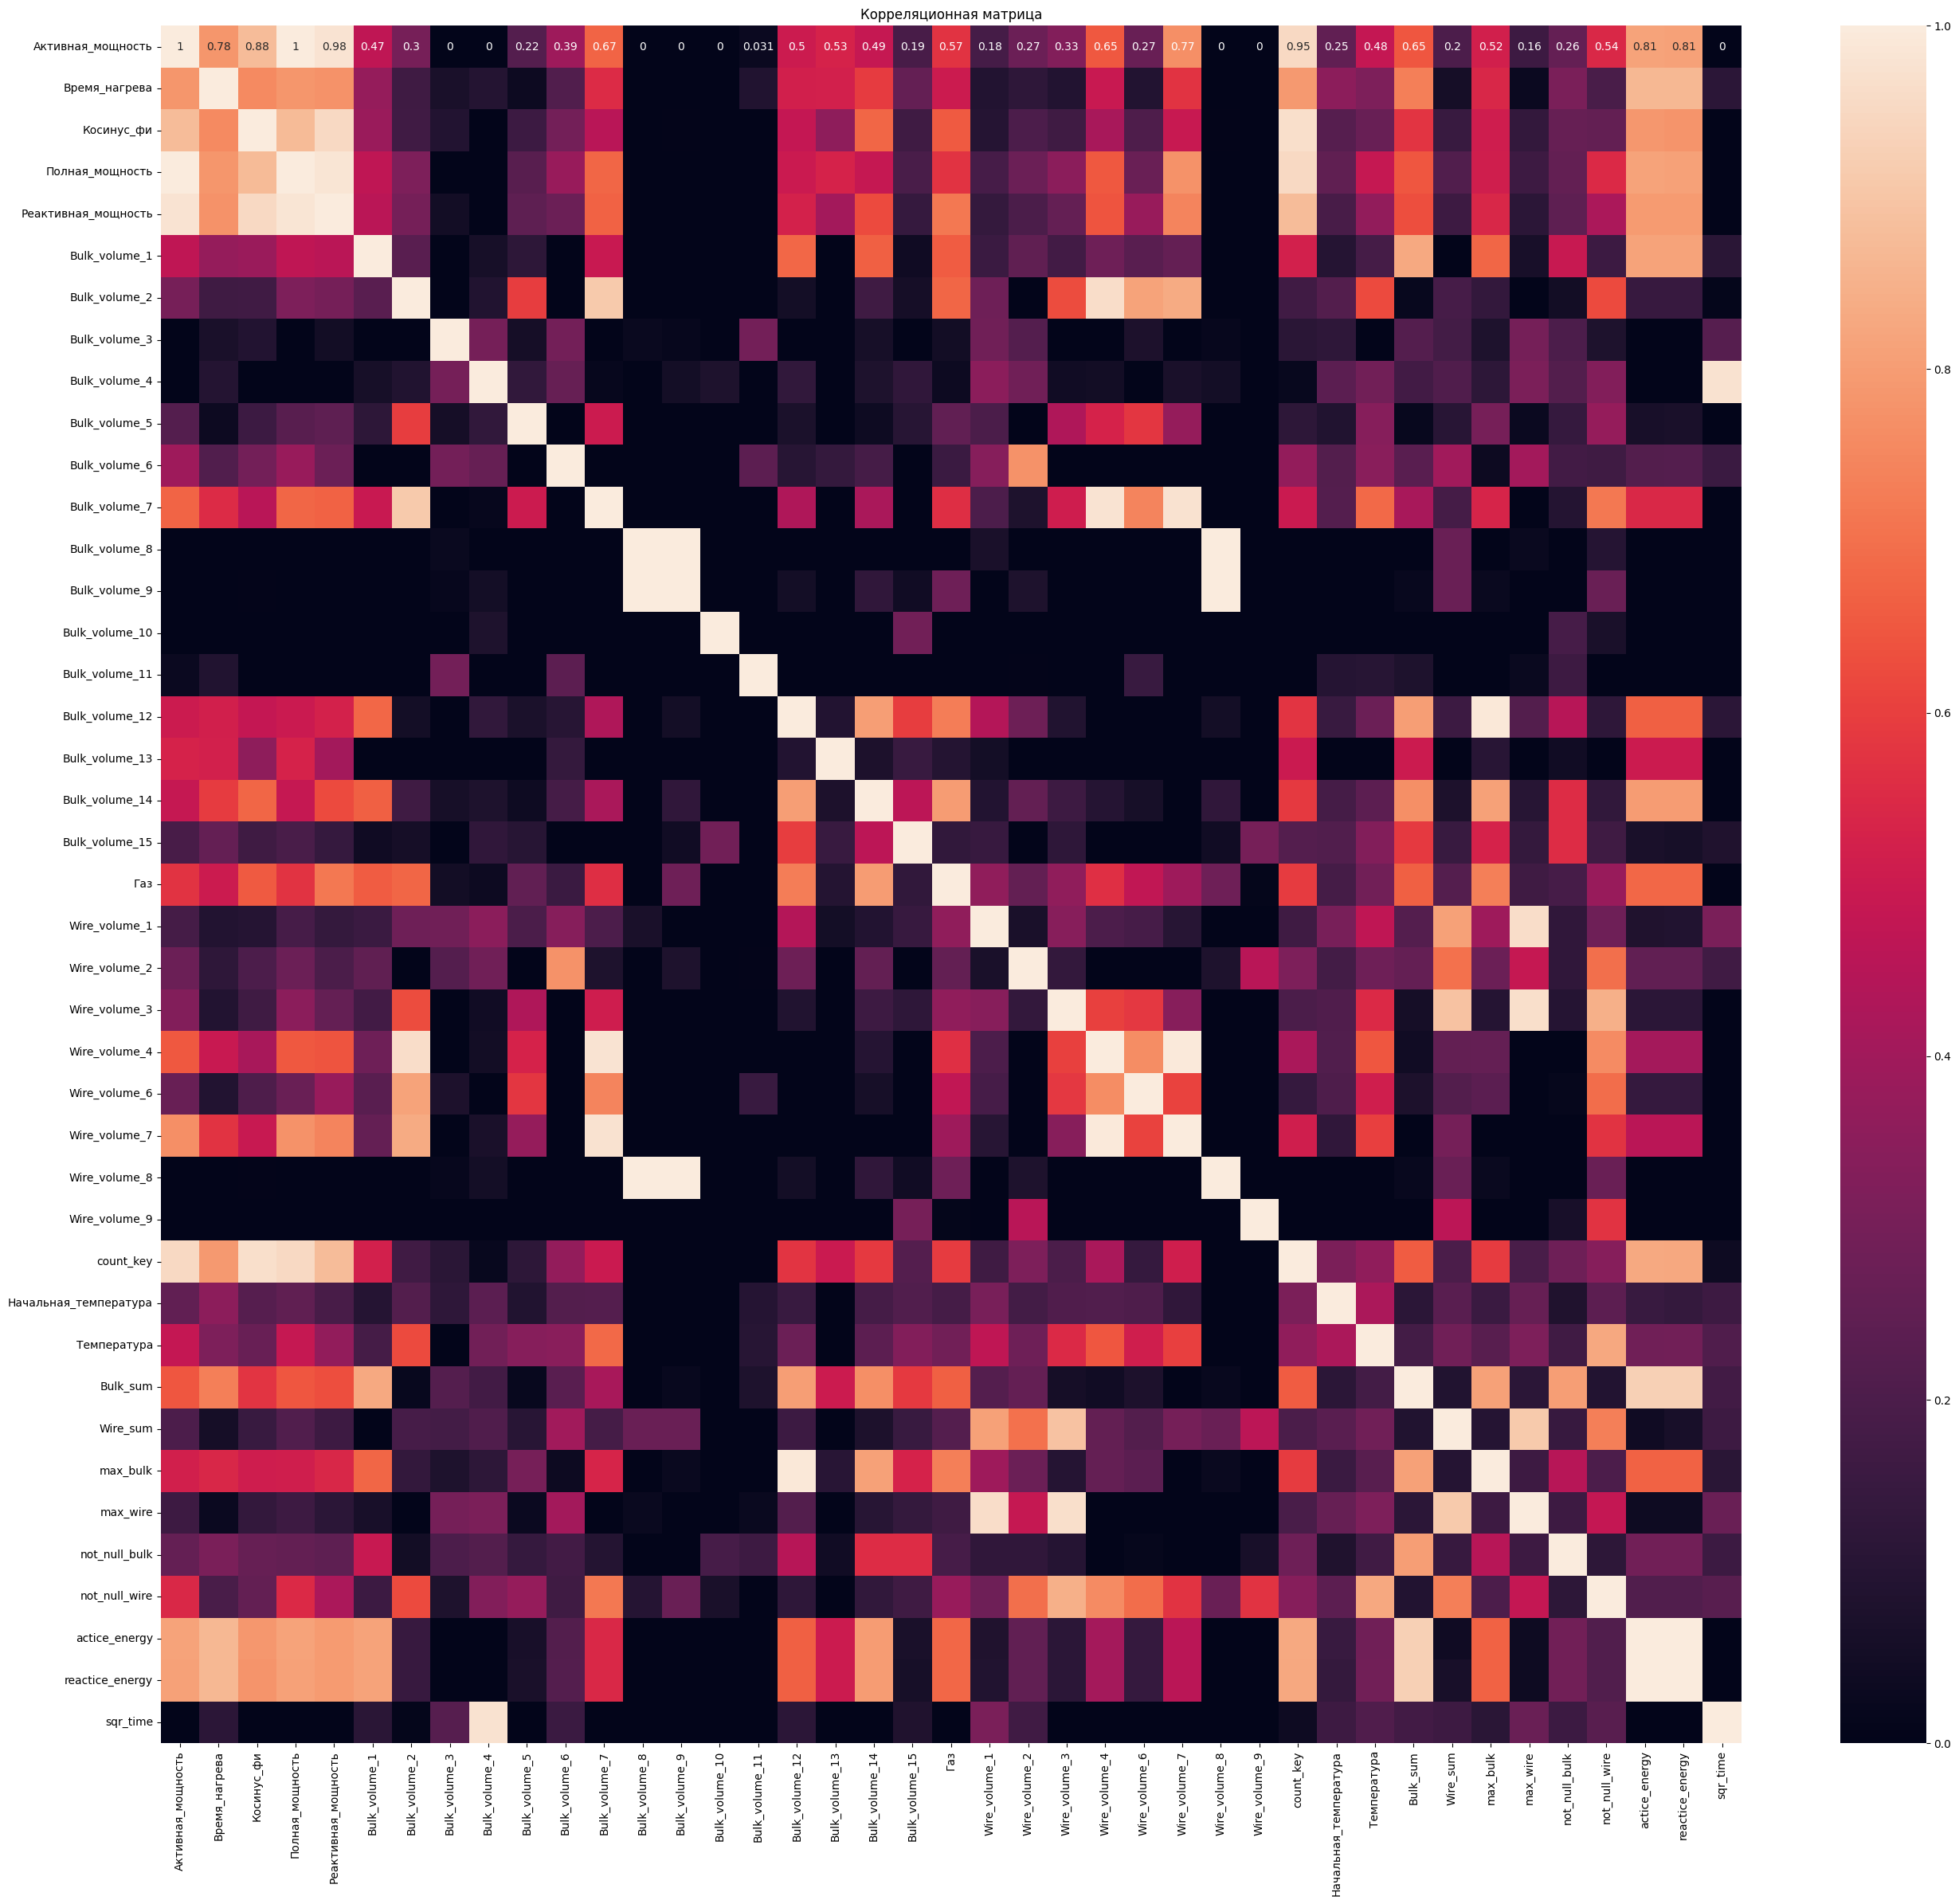

In [130]:
plt.figure(figsize=(32, 28))
sns.heatmap(result.drop('key', axis=1).phik_matrix(interval_cols=['Активная_мощность','Время_нагрева','Косинус_фи','Полная_мощность','Реактивная_мощность', 'Bulk_volume_1', 'Bulk_volume_2', 'Bulk_volume_3', 'Bulk_volume_4', 'Bulk_volume_5', 'Bulk_volume_6', 'Bulk_volume_7', 'Bulk_volume_8', 'Bulk_volume_9','Bulk_volume_10', 'Bulk_volume_11', 'Bulk_volume_12', 'Bulk_volume_13','Bulk_volume_14', 'Bulk_volume_15', 'Газ', 'Wire_volume_1','Wire_volume_2', 'Wire_volume_3', 'Wire_volume_4', 'Wire_volume_5','Wire_volume_6', 'Wire_volume_7', 'Wire_volume_8', 'Wire_volume_9','Температура', 'Bulk_sum', 'Wire_sum', 'max_bulk', 'max_wire', 'sqr_time', 'actice_energy', 'reactice_energy', 'count_key', 'Начальная_температура']), annot=True)
plt.title('Корреляционная матрица')
plt.show()

Избавимся от мультикорреляции, линейная зависимость наблюдается между Полной мощностью, Активной и реактивной, удалим активную и реактивную мощности. Далее я эксперементировала и удаляла разные комбинации признаков, пытаясь добиться нужной метрики качества.

In [131]:
result = result.drop(['Bulk_volume_4', 'actice_energy', 'Bulk_volume_12', 'Bulk_volume_8', 'Bulk_volume_9', 'Активная_мощность', 'Реактивная_мощность'], axis=1)

In [132]:
not_importance_feature = ['Bulk_volume_2', 'Bulk_volume_7', 'Bulk_volume_13', 'Wire_volume_7', 'Wire_volume_5', 'Wire_volume_4', 'Wire_volume_9', 'Косинус_фи']
result = result.drop(not_importance_feature, axis=1)

In [133]:
result.head()

,key,Время_нагрева,Полная_мощность,Bulk_volume_1,Bulk_volume_3,Bulk_volume_5,Bulk_volume_6,Bulk_volume_10,Bulk_volume_11,Bulk_volume_14,Bulk_volume_15,Газ,Wire_volume_1,Wire_volume_2,Wire_volume_3,Wire_volume_6,Wire_volume_8,count_key,Начальная_температура,Температура,Bulk_sum,Wire_sum,max_bulk,max_wire,not_null_bulk,not_null_wire,reactice_energy,sqr_time
0,1.0,1098.0,3.718736,0.0,0.0,0.0,0.0,0.0,0.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,5,1571.0,1613.0,553.0,60.059998,206.0,60.059998,4,1,2352.817458,1849.0
1,2.0,811.0,2.588349,0.0,0.0,0.0,0.0,0.0,0.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,4,1581.0,1602.0,582.0,96.052315,206.0,96.052315,4,1,1178.672527,5329.0
2,3.0,655.0,5.019223,0.0,0.0,0.0,0.0,0.0,0.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,5,1596.0,1599.0,544.0,91.160157,205.0,91.160157,4,1,1924.034335,1156.0
3,4.0,741.0,3.400038,0.0,0.0,0.0,0.0,0.0,0.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,4,1601.0,1625.0,595.0,89.063515,207.0,89.063515,4,1,1524.231072,6561.0
4,5.0,869.0,2.816980,0.0,0.0,0.0,0.0,0.0,0.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,4,1576.0,1602.0,584.0,98.352796,203.0,89.238236,4,2,1466.864179,6084.0


## Подготовка данных

Разделим данные на тренировочные и тестовые, предсказывать будем температуру сплава

In [134]:
y = result['Температура']
X = result.drop(['Температура', 'key'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.25, 
    random_state = RANDOM_STATE
   )

In [135]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

1743
581
1743
581


У нас все признаки непрерывные, масштабировать будем с помощью StandasdScaler и MinMaxScaler

In [136]:
num_columns = result.columns.drop(['key', 'Температура'])
num_columns

Index(['Время_нагрева', 'Полная_мощность', 'Bulk_volume_1', 'Bulk_volume_3',
       'Bulk_volume_5', 'Bulk_volume_6', 'Bulk_volume_10', 'Bulk_volume_11',
       'Bulk_volume_14', 'Bulk_volume_15', 'Газ', 'Wire_volume_1',
       'Wire_volume_2', 'Wire_volume_3', 'Wire_volume_6', 'Wire_volume_8',
       'count_key', 'Начальная_температура', 'Bulk_sum', 'Wire_sum',
       'max_bulk', 'max_wire', 'not_null_bulk', 'not_null_wire',
       'reactice_energy', 'sqr_time'],
      dtype='object')

Создадим пайплайны для подготовки признаков выбора лучше модели и подбора гиперпараметров.

In [137]:
num_pipe = Pipeline(
    [
        ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler())
    ]
)

In [138]:
data_preprocessor = ColumnTransformer(
    [
        ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

In [139]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE)) 
    ]  
)

## Обучение моделей машинного обучения

Одельно обучим модель линейной регрессии, не будет ее прогонять через подбор гиперпараметров, так как их нет.

In [140]:
model_linear = LinearRegression()

In [141]:
X_train_new = pipe_final.named_steps['preprocessor'].fit_transform(X_train)

In [142]:
result_linear = cross_val_score(model_linear, X_train_new, y_train, cv=5, scoring='neg_mean_absolute_error')
-result_linear.mean()

6.435579108231005

Среднее занчение метрики линейной регерсии при кросс-валидации равно 6,4

У меня долго не получалась нужная метрика, поэтому я обучала несколько разных моделей, пытаясь получить нужную: дерево решений, модель случайных соседей, LGBMRegressor (модель показывала неплохие результаты, но все же не лучшая, CatBoostRegressor и метод опорных векторов.

In [143]:
param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,10),
        'models__max_features': range(2,10),
        'models__min_samples_split': range(2,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(5,40),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE, learning_rate=0.01)],
        'models__num_leaves': range(1,10),
        'models__max_depth': range(10,31),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
   },
    {
  #      'models': [XGBRegressor()],
  #      'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [CatBoostRegressor(learning_rate=0.1, allow_writing_files=False)],
        'models__n_estimators': range(5,200),
        'models__depth': range(5,10),
        'models__subsample': [0.01, 0.1, 1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [SVR()],
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
        'models__C': [0.01, 0.1, 1, 2, 5, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [144]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='neg_mean_absolute_error',  
    n_jobs=-1,
    random_state = RANDOM_STATE,
    error_score='raise',
    n_iter=20
)

In [145]:
randomized_search.fit(X_train, y_train)

0:	learn: 11.0961226	total: 55.4ms	remaining: 7.25s
1:	learn: 10.8412927	total: 62.8ms	remaining: 4.08s
2:	learn: 10.5952326	total: 67.4ms	remaining: 2.9s
3:	learn: 10.4259275	total: 71.2ms	remaining: 2.28s
4:	learn: 10.1986533	total: 75.2ms	remaining: 1.91s
5:	learn: 10.0458570	total: 79.5ms	remaining: 1.67s
6:	learn: 9.8724708	total: 83.6ms	remaining: 1.49s
7:	learn: 9.7296936	total: 87.8ms	remaining: 1.36s
8:	learn: 9.5942598	total: 91.9ms	remaining: 1.25s
9:	learn: 9.4738743	total: 95.9ms	remaining: 1.17s
10:	learn: 9.3567903	total: 99.9ms	remaining: 1.1s
11:	learn: 9.2547096	total: 104ms	remaining: 1.04s
12:	learn: 9.0985226	total: 108ms	remaining: 987ms
13:	learn: 9.0026876	total: 112ms	remaining: 944ms
14:	learn: 8.9524000	total: 116ms	remaining: 907ms
15:	learn: 8.8780960	total: 120ms	remaining: 873ms
16:	learn: 8.7966035	total: 125ms	remaining: 844ms
17:	learn: 8.7689863	total: 126ms	remaining: 796ms
18:	learn: 8.7075258	total: 130ms	remaining: 774ms
19:	learn: 8.6555002	total

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('simpleImputer_num',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['Время_нагрева', 'Полная_мощность', 'Bulk_volume_1', 'Bulk_volume_3',
       'Bulk_volume_5', 'Bulk_volume_6', 'Bulk_volume...
                                         'models__n_estimators': range(5, 200),
                                         'models__subsample': [0.01, 0.1, 1],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVR()],
                                         'models__C': [0.01, 0.1, 1, 2, 5, 10],
                                         'models__kernel': ['linear', 'poly',
                                                            'rbf', 'sigmoid',
                                                            'precomputed'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=250325, scoring='neg_mean_absolute_error')

In [146]:
best_model = randomized_search.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['Время_нагрева', 'Полная_мощность', 'Bulk_volume_1', 'Bulk_volume_3',
       'Bulk_volume_5', 'Bulk_volume_6', 'Bulk_volume_10', 'Bulk_volume_11',
       'Bulk_volume_14', 'Bulk_volume_15', 'Газ', 'Wire_volume_1',
       'Wire_volume_2', 'Wire_volume_3', 'Wire_volume_6', 'Wire_volume_8',
       'count_key', 'Начальная_температура', 'Bulk_sum', 'Wire_sum',
       'max_bulk', 'max_wire', 'not_null_bulk', 'not_null_wire',
       'reactice_energy', 'sqr_time'],
      dtype='object'))])),
                ('models',
                 <catboost.core.CatBoostRegressor object at 0x000001CE6AC3B610>)])

In [147]:
randomized_search.best_params_

{'preprocessor__num': MinMaxScaler(),
 'models__subsample': 1,
 'models__n_estimators': 132,
 'models__depth': 6,
 'models': <catboost.core.CatBoostRegressor at 0x1ce682c65d0>}

Лучшей моделью оказалась модель CatBoostRegressor

In [148]:
best_metric = -randomized_search.best_score_
best_metric

6.248756915077506

GridSearchCV слишком долго считает, остановилась на RandomizedSearchCV

## Выбор и проверка лучшей модели

In [149]:
y_pred = best_model.predict(X_test)
metric = mean_absolute_error(y_pred, y_test)
metric

6.035935050152458

Переобучения не видно

### Проведем анализ важности признаков

Построим график Shap

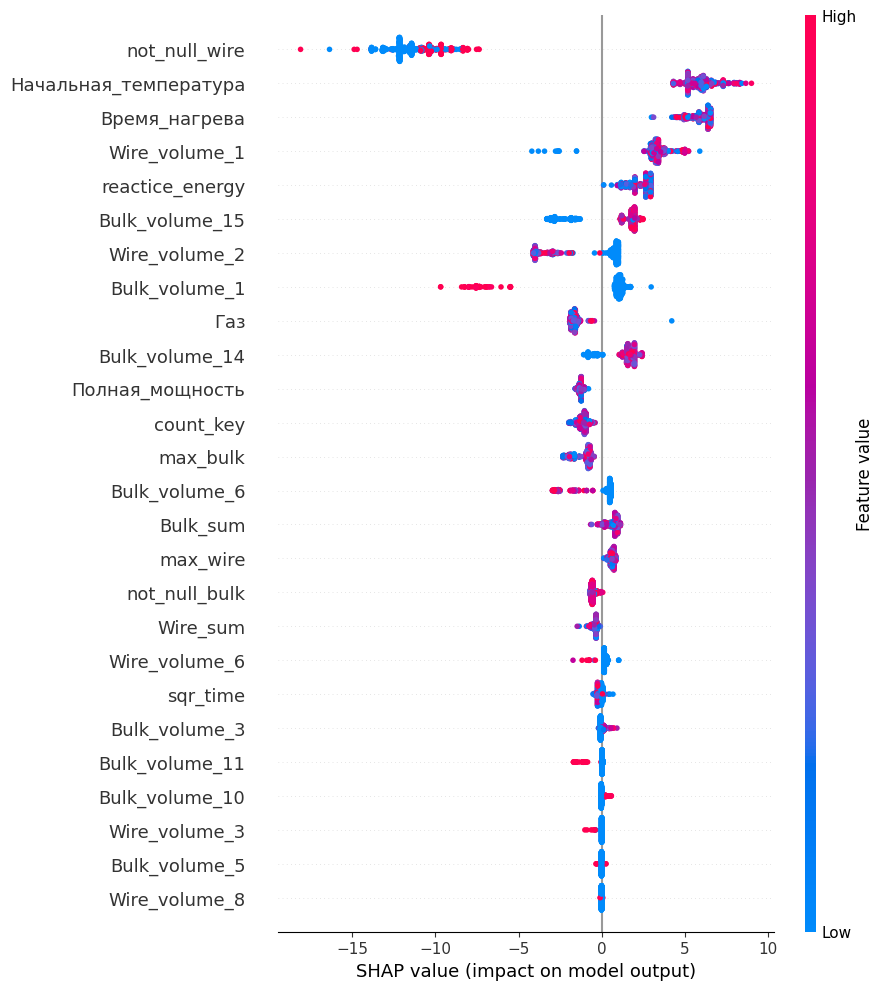

In [150]:
explainer = shap.TreeExplainer(randomized_search.best_estimator_.named_steps['models'])
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values, max_display=40) 

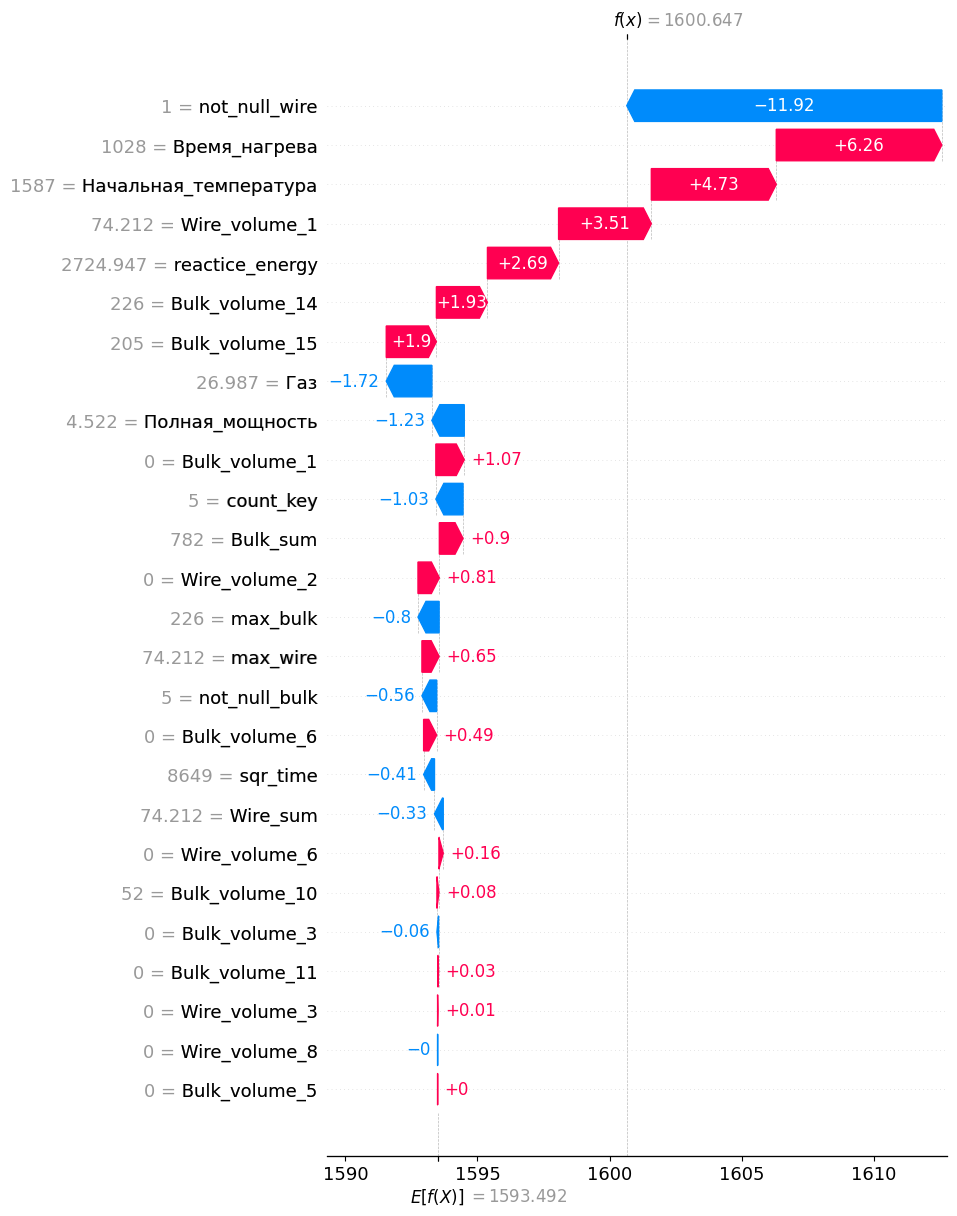

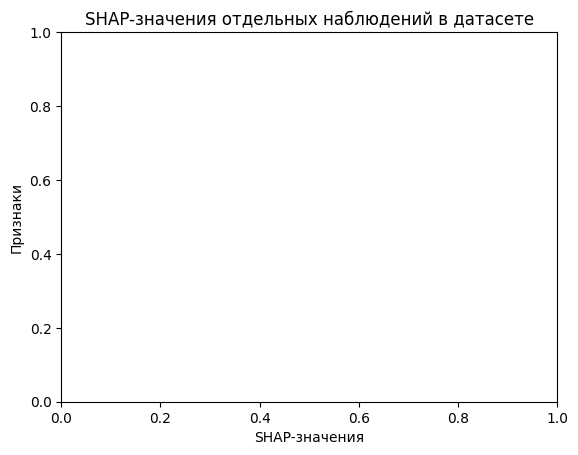

In [151]:
shap.plots.waterfall(shap_values[23], max_display=40) 
plt.title('SHAP-значения отдельных наблюдений в датасете')
plt.xlabel('SHAP-значения')
plt.ylabel('Признаки')
plt.show()

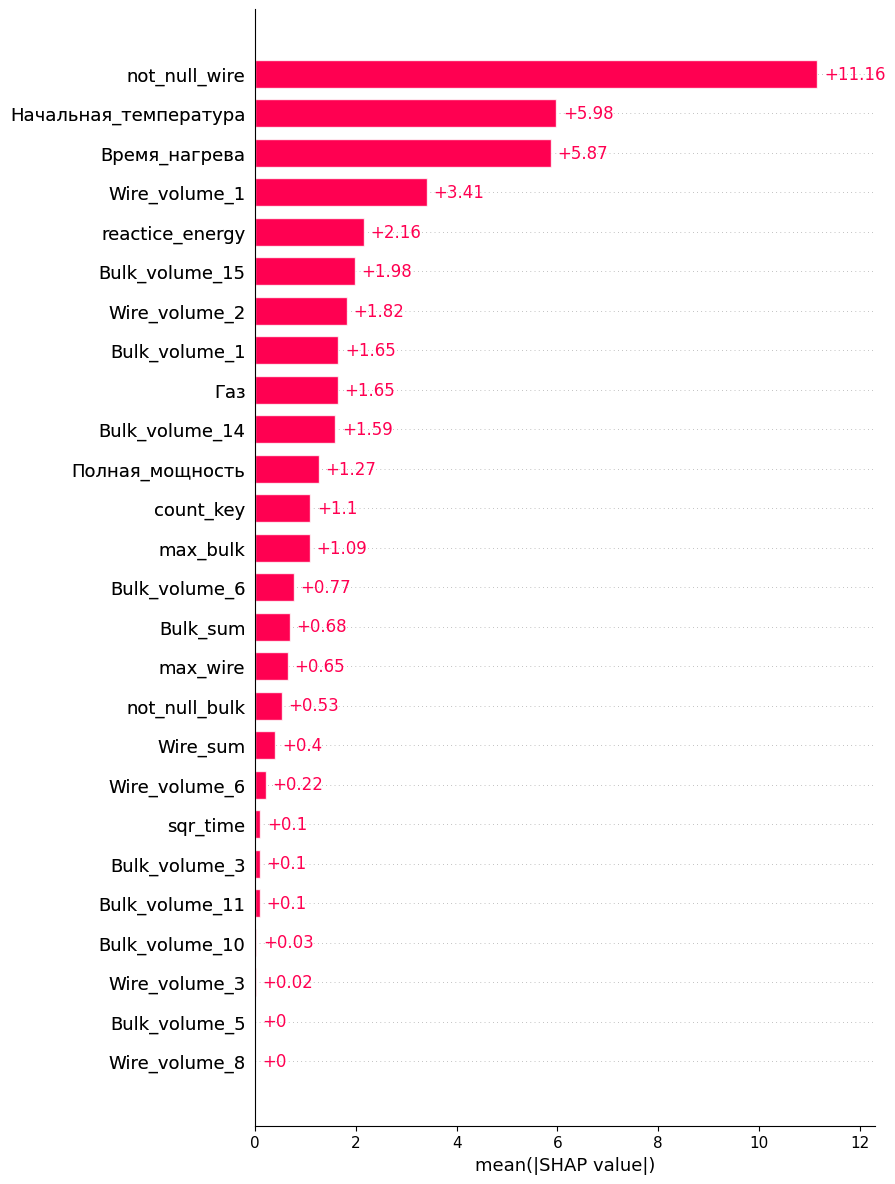

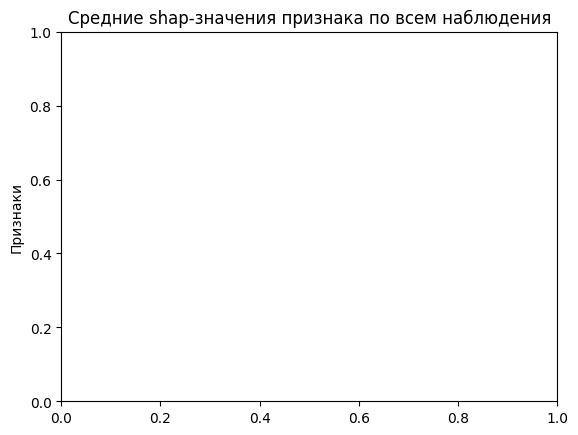

In [152]:
shap.plots.bar(shap_values, max_display=40)
plt.title('Средние shap-значения признака по всем наблюдения')
plt.ylabel('Признаки')
plt.show()

## Общий вывод и рекомендации заказчику

Целью моей работы была разработка предсказательной модели температуры сплава. Мне необходимо было обучить не менее трех моделей регрессии, выбрать лучшую и получить метрику на тестовой выборке не больше 6,8. Для решения задачи я сделала следующее:

1. Загрузила и ознакомилась с данными
2. Провела предобработку данных и исследовательский анализ данных
* Переименовала названия столбцов, чтобы с ними было проще работать
* Откорректировала типы данных
* Проверила данные на явные дубликаты, их не оказалось
* Заполнила пропуски, пропуски в целевой переменной решила не заполнять, чтобы не загрязнять данные
* Построила графики распределения и ящик с усами для всех признаков и удалила аномальные значения
3. Объединила датафреймы
4. Провела исследовательский анализ объединенных данных, удалила коррелирующие признаки и добавила новые, а именно: время нагрева дугой, полную мощность, cosϕ, количество плавок, начальную температуру нагрева и максимальную температуру нагрева, сумму присадок Bulk, сумму проволочных присадок, максимальное значение среди всех столбцов Bulk, максимальное значение среди всех столбцов Wire, количество ненулевых значений в столбцах Bulk, количество ненулевых значений в столбцах Wire, активную энергию, реактивную энергию
5. Подготовила данные для обучения, разделила данные на тренировочные и тестовые, масштабировала признаки
6. Обучила модели: линейную регрессию, дерево решений, модель случайных соседей, LGBMRegressor, CatBoostRegressor и метод опорных векторов. 
7. Выбрала лучшую и проверила метрику на тестовой выборке: лучшей оказалась CatBoostRegressor с метрикой качества MAE 6,2, LGBMRegressor тоже показывала неплохие результаты. Метрика на тестовых данных получилась равной 6,0.

Признаки, используемые для обучения лучшей модели, расположенные в порядке уменьшения влияние на предсказания модели:
* not_null_wire (количество присадок wire)
* Начальная_температура (сплава)
* Время_нагрева
* Bulk_volume_14
* Wire_volume_1
* Газ
* Bulk_volume_15
* max_bulk (присадка bulk с максимальным объемом)
* Wire_sum (общий объем присадок wire)
* Wire_volume_2
* Bulk_volume_6
* Bulk_volume_1
* count_key (количество плавок)
* not_null_bulk (количество присадок bulk)
* reactice_energy (реактивная энергия)
* Полная_мощность
* Bulk_sum (общий объем присадок bulk)
* sqr_time (время плавки, возведенное в квадрат)
* max_wire (присадка wire с максимальным объемом)
* Bulk_volume_3
* Wire_volume_6
* Wire_volume_3
* Bulk_volume_5
* Bulk_volume_11
* Bulk_volume_10
* Wire_volume_8

Очень долго не могла добиться нужной метрики, поэтому снчала добавляла новые модели, потом признаки по одному, эксперементировала с удалением признаков. Обучала модели по-отдельности. Сначала все модели показывали похожую метрику, около 10.6. Ситуация поменялась, когда я добавила новый признак `Конечную температуру`, тогда метрика спустилась до 6,0

Ключевыми шагами являются предобработка данных, очистка их от аномальных значений и удаление пропусков. Но больше всего на метрику качества повлияло создание новых признаков. При этом я заметила, что удаление каких-либо признаков, не сильно влияет на качество модели.

Лучшую метрику показывала модель CatBoostRegressor со следующими гиперпараметрами:

- 'models__subsample': 1, 
- 'models__n_estimators': 132,
- 'models__depth': 6,6,
 
Метод масштабирования: MinMaxScaler()

Для улучшения модели я бы рекомендовала собирать как можно больше признаков, например химический состав присадок, так как они оказывают первоочередное влияние на качество работы модели, а также мне пришлось удалить много строк с пропущенными занчениями в столбце с целевым признаком, хотелось бы получить эти данные в будущем. 

Я бы рекомендовала компании построить модель для регулирования качества и объема добавленных присадок, что может в дальнейшем сократить количество плавок и поможет компании сэкономить. Приходится проводить много экспериментов, чтобы получить сталь нужного качества, а зная химический состав присадок, можно сначала построить модель и занчительно сэкономить на экспериментах.

На начальную температуру сплава в первую очередь влияют тип используемых электродов и потребляемая мощность. Если мы будем понимать, какая начальная температура будет оптимальной, мы сможем управлять мощностью электродов, чтобы добиться этого значения.

В будущем можно будет решить задачу классификации и выявить факторы, которые привели к выходу за обозначенные рамки температурных колебаний. Минимизировав влияние этих факторов, производство сможет снизить температурный разброс, что, в свою очередь, позволит снизить энергопотребление.